# SHAP Explainability Notebook
Clinical trial outcome models (HINT → CTOD)

This notebook explains what the XGBoost models are doing across phases and across datasets.
We start with HINT (in-domain), then run SHAP on CTOD (out-of-domain), then compare.


In [1]:
# 1. Install (run once)
!pip install shap xgboost numpy pandas scipy



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 2. Imports
import numpy as np
import pandas as pd
import json
from scipy.sparse import csr_matrix
import xgboost as xgb
import shap

shap.initjs()


## 3. Helper
We saved data as sparse .npz. This function rebuilds it.


In [3]:
def load_sparse_csr(path):
    f = np.load(path)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])


## 4. HINT — Phase I
Load HINT phase I, load model, align columns, run SHAP, get feature importance.


In [4]:
# paths for HINT phase I
hint_p1_train_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\phase_I\X_train.npz"
hint_p1_test_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\phase_I\X_test.npz"
hint_p1_model_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_I\xgb_model.json"
hint_p1_feat_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_I\feature_names.json"
# load data
X_hint_p1_train = load_sparse_csr(hint_p1_train_path)
X_hint_p1_test  = load_sparse_csr(hint_p1_test_path)

# load model
hint_p1_model = xgb.Booster()
hint_p1_model.load_model(hint_p1_model_path)
hint_p1_nfeat = hint_p1_model.num_features()
print("HINT phase I model expects:", hint_p1_nfeat)

# align
X_hint_p1_train = X_hint_p1_train[:, :hint_p1_nfeat]
X_hint_p1_test  = X_hint_p1_test[:, :hint_p1_nfeat]

# feature names
try:
    with open(hint_p1_feat_path, "r") as f:
        hint_p1_feature_names = json.load(f)
except FileNotFoundError:
    hint_p1_feature_names = [f"f{i}" for i in range(hint_p1_nfeat)]
hint_p1_feature_names = hint_p1_feature_names[:hint_p1_nfeat]

# explainer
hint_p1_explainer = shap.TreeExplainer(hint_p1_model)

# full SHAP in batches
batch_size = 300
n_rows = X_hint_p1_test.shape[0]
sum_abs = np.zeros(hint_p1_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_hint_p1_test[start:end])
    sv = hint_p1_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

hint_p1_mean_abs = sum_abs / total

# table
idx = np.argsort(hint_p1_mean_abs)[::-1]
phase1_importance = pd.DataFrame({
    "feature": np.array(hint_p1_feature_names)[idx],
    "mean_abs_shap": hint_p1_mean_abs[idx]
})
phase1_importance.head(20)


HINT phase I model expects: 1000


,feature,mean_abs_shap
0,num__enrollment_log1p,0.761104
1,pos__criteria__gree,0.071216
2,pos__criteria__ (e.g,0.051033
3,pos__criteria__cipan,0.042765
4,pos__criteria__ 1.,0.037980
5,pos__criteria__ mal,0.031519
6,pos__criteria__ coun,0.029522
7,pos__criteria__ acu,0.026588
8,pos__criteria__ (in,0.026407
9,pos__criteria__ alc,0.025872


### Plot HINT Phase I (sample)


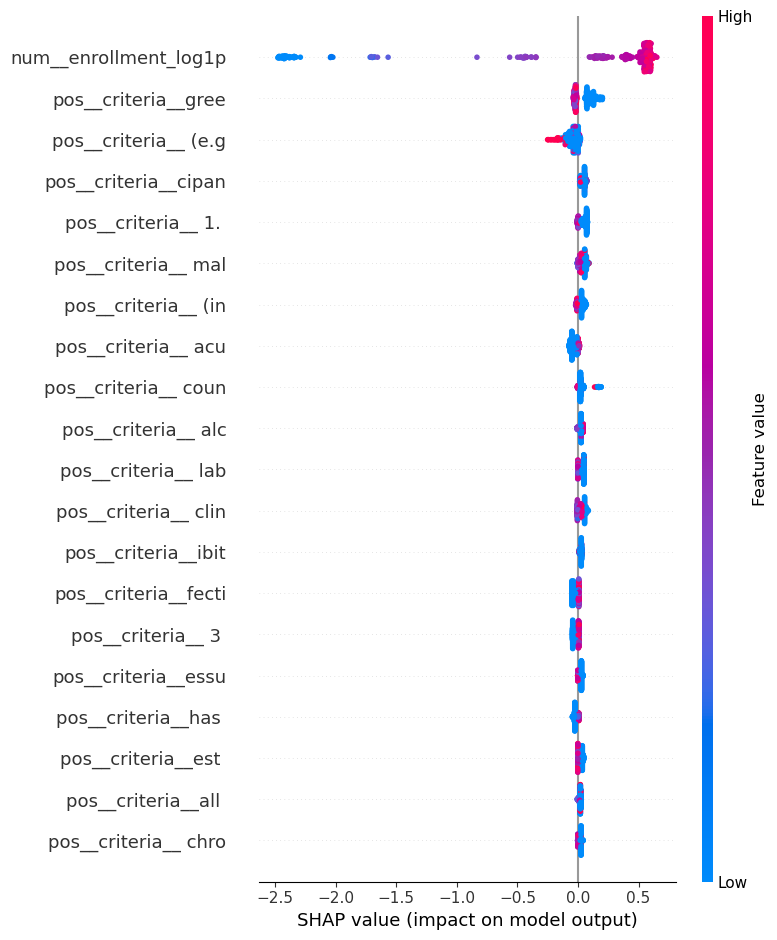

In [5]:
X_plot = X_hint_p1_test[:400].toarray()
d_plot = xgb.DMatrix(X_hint_p1_test[:400])
sv_plot = hint_p1_explainer.shap_values(d_plot)

shap.summary_plot(sv_plot, X_plot, feature_names=hint_p1_feature_names)


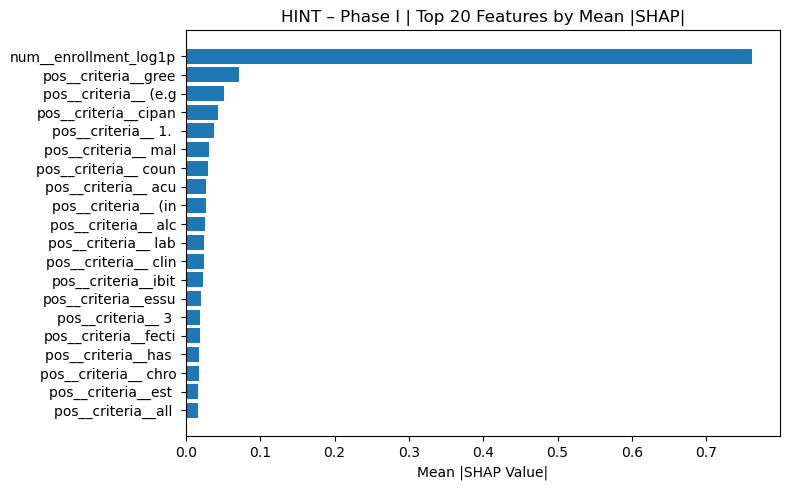

In [6]:
import matplotlib.pyplot as plt

top = phase1_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("HINT – Phase I | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


## 5. HINT — Phase II
Same as phase I, new paths.


In [7]:
hint_p2_test_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\phase_II\X_test.npz"
hint_p2_model_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\xgb_model.json"
hint_p2_feat_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\feature_names.json"
X_hint_p2_test = load_sparse_csr(hint_p2_test_path)

hint_p2_model = xgb.Booster()
hint_p2_model.load_model(hint_p2_model_path)
hint_p2_nfeat = hint_p2_model.num_features()
print("HINT phase II model expects:", hint_p2_nfeat)

X_hint_p2_test = X_hint_p2_test[:, :hint_p2_nfeat]

try:
    with open(hint_p2_feat_path, "r") as f:
        hint_p2_feature_names = json.load(f)
except FileNotFoundError:
    hint_p2_feature_names = [f"f{i}" for i in range(hint_p2_nfeat)]
hint_p2_feature_names = hint_p2_feature_names[:hint_p2_nfeat]

hint_p2_explainer = shap.TreeExplainer(hint_p2_model)

batch_size = 300
n_rows = X_hint_p2_test.shape[0]
sum_abs = np.zeros(hint_p2_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_hint_p2_test[start:end])
    sv = hint_p2_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

hint_p2_mean_abs = sum_abs / total

idx = np.argsort(hint_p2_mean_abs)[::-1]
phase2_importance = pd.DataFrame({
    "feature": np.array(hint_p2_feature_names)[idx],
    "mean_abs_shap": hint_p2_mean_abs[idx]
})
phase2_importance.head(20)


HINT phase II model expects: 1000


,feature,mean_abs_shap
0,num__enrollment_log1p,1.104601
1,pos__criteria__erio,0.080351
2,pos__criteria__fine,0.074716
3,pos__criteria__ bloo,0.068501
4,pos__criteria__hemot,0.061842
5,pos__criteria__ \<,0.060954
6,pos__criteria__denc,0.059370
7,pos__criteria__diot,0.052324
8,"pos__criteria__es,",0.051258
9,pos__criteria__ nor,0.051233


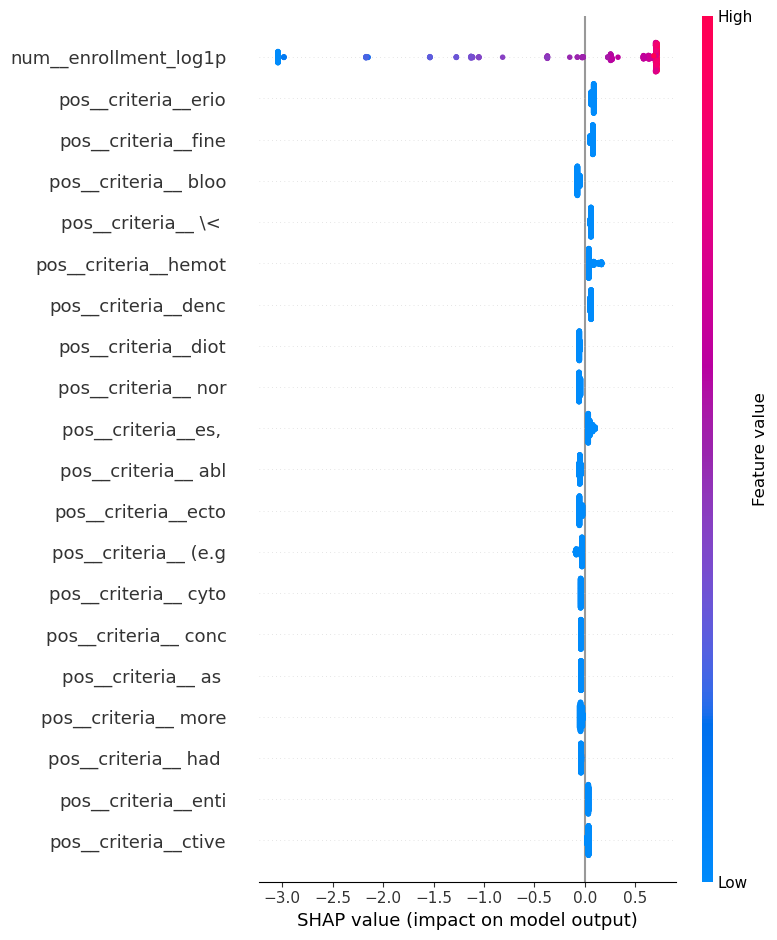

In [8]:
X_plot = X_hint_p2_test[:400].toarray()
d_plot = xgb.DMatrix(X_hint_p2_test[:400])
sv_plot = hint_p2_explainer.shap_values(d_plot)

shap.summary_plot(sv_plot, X_plot, feature_names=hint_p2_feature_names)


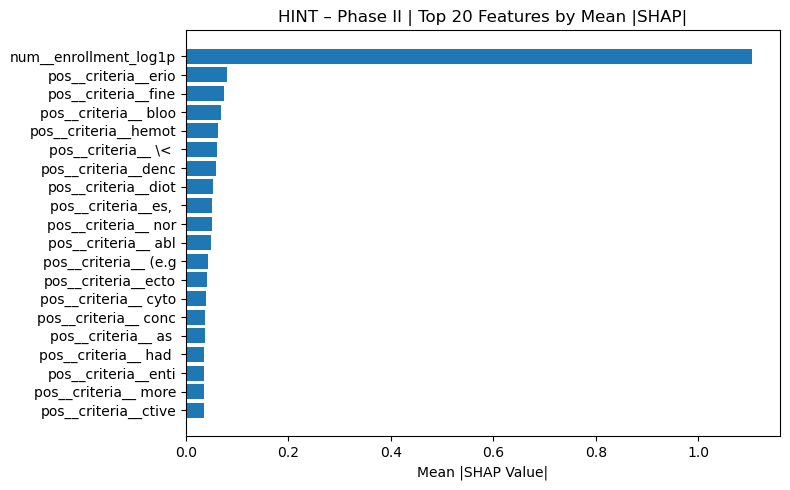

In [9]:
top = phase2_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("HINT – Phase II | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


## 6. HINT — Phase III


In [10]:
# HINT phase III paths (new hybrid package)
hint_p3_test_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\phase_III\X_test.npz"
hint_p3_model_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_III\xgb_model.json"
hint_p3_feat_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_III\feature_names.json"

X_hint_p3_test = load_sparse_csr(hint_p3_test_path)

hint_p3_model = xgb.Booster()
hint_p3_model.load_model(hint_p3_model_path)
hint_p3_nfeat = hint_p3_model.num_features()
print("HINT phase III model expects:", hint_p3_nfeat)

X_hint_p3_test = X_hint_p3_test[:, :hint_p3_nfeat]

try:
    with open(hint_p3_feat_path, "r") as f:
        hint_p3_feature_names = json.load(f)
except FileNotFoundError:
    hint_p3_feature_names = [f"f{i}" for i in range(hint_p3_nfeat)]
hint_p3_feature_names = hint_p3_feature_names[:hint_p3_nfeat]

hint_p3_explainer = shap.TreeExplainer(hint_p3_model)

batch_size = 300
n_rows = X_hint_p3_test.shape[0]
sum_abs = np.zeros(hint_p3_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_hint_p3_test[start:end])
    sv = hint_p3_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

hint_p3_mean_abs = sum_abs / total

idx = np.argsort(hint_p3_mean_abs)[::-1]
phase3_importance = pd.DataFrame({
    "feature": np.array(hint_p3_feature_names)[idx],
    "mean_abs_shap": hint_p3_mean_abs[idx]
})
phase3_importance.head(20)


HINT phase III model expects: 1000


,feature,mean_abs_shap
0,num__enrollment_log1p,1.026972
1,pos__criteria__ nor,0.104357
2,pos__criteria__ info,0.101427
3,pos__criteria__ 3.,0.100559
4,pos__criteria__eivin,0.090287
5,pos__criteria__ente,0.086926
6,pos__criteria__chil,0.084380
7,pos__criteria__ pla,0.080672
8,pos__criteria__ app,0.079515
9,pos__criteria__ lim,0.077401


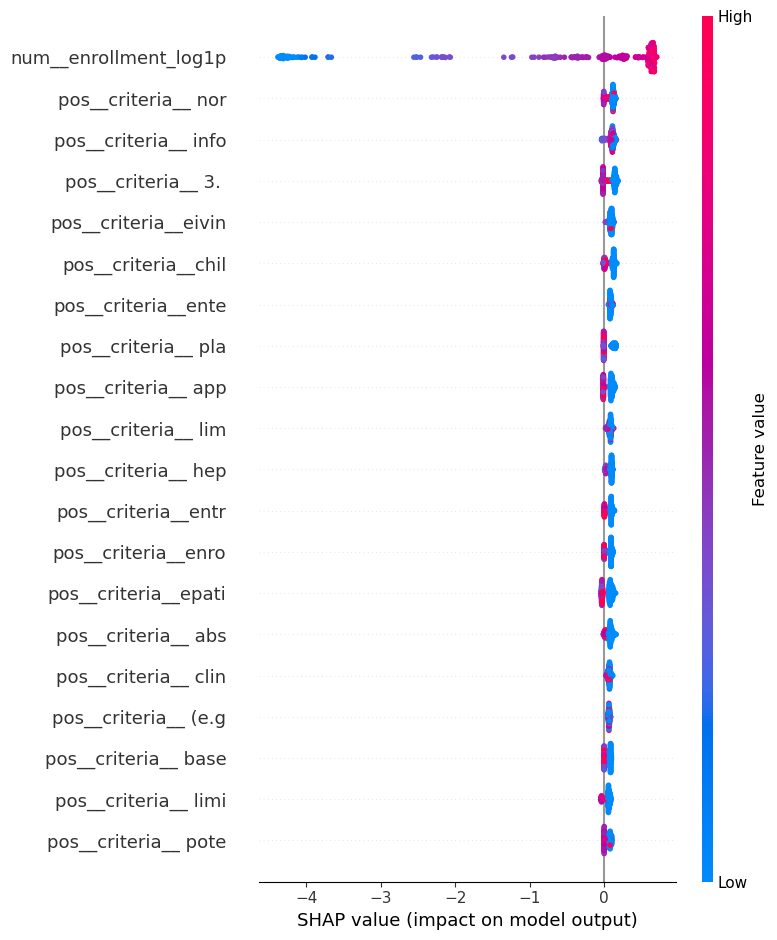

In [11]:
X_plot = X_hint_p3_test[:400].toarray()
d_plot = xgb.DMatrix(X_hint_p3_test[:400])
sv_plot = hint_p3_explainer.shap_values(d_plot)

shap.summary_plot(sv_plot, X_plot, feature_names=hint_p3_feature_names)


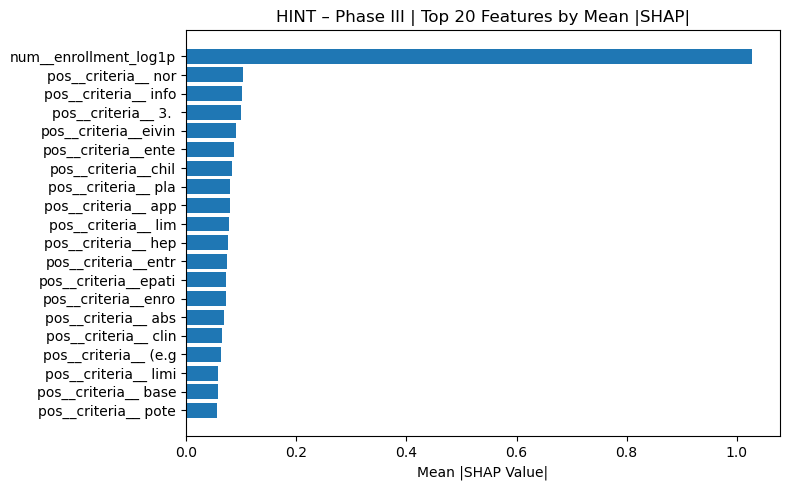

In [12]:
top = phase3_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("HINT – Phase III | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


In [14]:
import json
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

def computeshapimportance(model_path, X_path, feat_path, batchsize=300):
    # load model
    model = xgb.Booster()
    model.load_model(model_path)
    nfeat = model.num_features()

    # load sparse X and align to model features
    X = load_sparse_csr(X_path)
    X = X[:, :nfeat]

    # feature names
    try:
        with open(feat_path, "r", encoding="utf-8") as f:
            featurenames = json.load(f)[:nfeat]
    except Exception:
        featurenames = [f"f{i}" for i in range(nfeat)]

    # SHAP explainer
    explainer = shap.TreeExplainer(model)
    nrows = X.shape[0]
    sumabs = np.zeros(nfeat, dtype=float)
    total = 0

    for start in range(0, nrows, batchsize):
        end = min(start + batchsize, nrows)
        sv = explainer.shap_values(X[start:end])
        sumabs += np.abs(sv).sum(axis=0)
        total += (end - start)

    meanabs = sumabs / max(total, 1)
    idx = np.argsort(meanabs)[::-1]

    return pd.DataFrame({
        "feature": np.array(featurenames)[idx],
        "meanabsshap": meanabs[idx]
    })



In [15]:
# HINT Phase I
phase1importance = computeshapimportance(
    hint_p1_model_path,
    hint_p1_test_path,
    hint_p1_feat_path,
)

# HINT Phase II
phase2importance = computeshapimportance(
    hint_p2_model_path,
    hint_p2_test_path,
    hint_p2_feat_path,
)

# HINT Phase III (define these three first, matching your folder layout)
hint_p3_test_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\phase_III\X_test.npz"
hint_p3_model_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_III\xgb_model.json"
hint_p3_feat_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_III\feature_names.json"

phase3importance = computeshapimportance(
    hint_p3_model_path,
    hint_p3_test_path,
    hint_p3_feat_path,
)


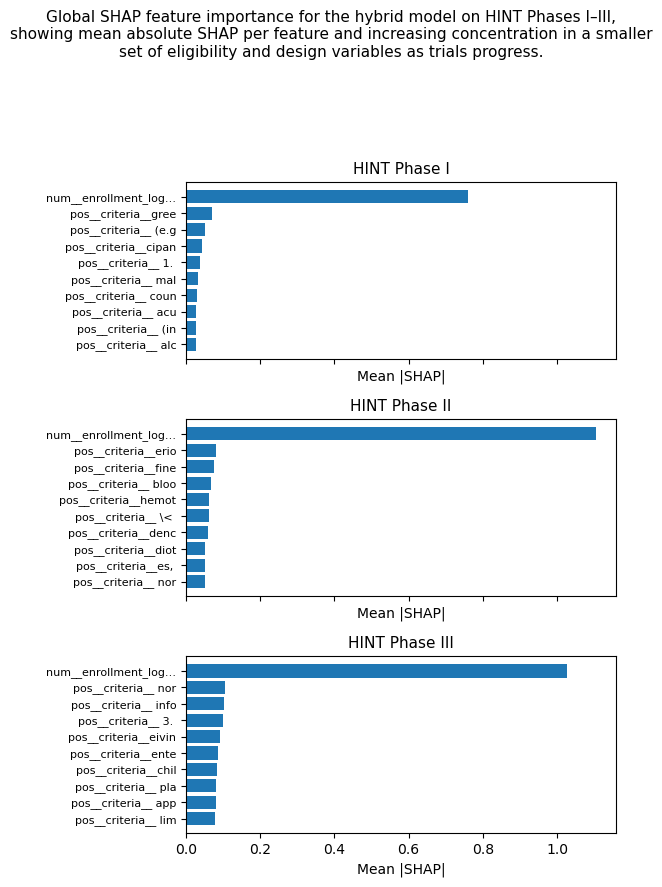

In [18]:
import matplotlib.pyplot as plt

def tidy_labels(s, max_len=20):
    s = str(s)
    return (s[:max_len-1] + "…") if len(s) > max_len else s

def plot_hint_global_shap_rows(phase_imps, phase_labels, top_k=10):
    n_phases = len(phase_imps)
    fig, axes = plt.subplots(n_phases, 1, figsize=(6, 9), sharex=True)

    if n_phases == 1:
        axes = [axes]

    for ax, df_imp, label in zip(axes, phase_imps, phase_labels):
        df_top = df_imp.sort_values("meanabsshap", ascending=False).head(top_k)
        labels = [tidy_labels(f) for f in df_top["feature"]]
        ax.barh(labels, df_top["meanabsshap"], color="#1f77b4")
        ax.invert_yaxis()
        ax.set_title(f"HINT {label}", fontsize=11)
        ax.set_xlabel("Mean |SHAP|")
        ax.tick_params(axis="y", labelsize=8)

    fig.suptitle(
        "Global SHAP feature importance for the hybrid model on HINT Phases I–III,\n"
        "showing mean absolute SHAP per feature and increasing concentration in a smaller\n"
        "set of eligibility and design variables as trials progress.",
        fontsize=11
    )
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig("hint_global_shap_phases_I_III_rows.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_hint_global_shap_rows(
    [phase1importance, phase2importance, phase3importance],
    ["Phase I", "Phase II", "Phase III"],
    top_k=10
)


## 7. CTOD — Phase I
Same model as HINT phase I, but data from CTOD.


In [20]:
ctod_p1_test_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_I\X_test_joined.npz"

X_ctod_p1_test = load_sparse_csr(ctod_p1_test_path)
print("CTOD phase I shape:", X_ctod_p1_test.shape)

# reuse hint phase I model and feature names
X_ctod_p1_test = X_ctod_p1_test[:, :hint_p1_nfeat]

batch_size = 300
n_rows = X_ctod_p1_test.shape[0]
sum_abs = np.zeros(hint_p1_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_ctod_p1_test[start:end])
    sv = hint_p1_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

ctod_p1_mean_abs = sum_abs / total

idx = np.argsort(ctod_p1_mean_abs)[::-1]
ctod_importance = pd.DataFrame({
    "feature": np.array(hint_p1_feature_names)[idx],
    "mean_abs_shap": ctod_p1_mean_abs[idx]
})
ctod_importance.head(20)


CTOD phase I shape: (5022, 13615)


,feature,mean_abs_shap
0,num__enrollment_log1p,0.648737
1,pos__criteria__gree,0.076930
2,pos__criteria__ 1.,0.054056
3,pos__criteria__cipan,0.043572
4,pos__criteria__ (e.g,0.042000
5,pos__criteria__ mal,0.035656
6,pos__criteria__ acu,0.031200
7,pos__criteria__ lab,0.030029
8,pos__criteria__ clin,0.028425
9,pos__criteria__ (in,0.028299


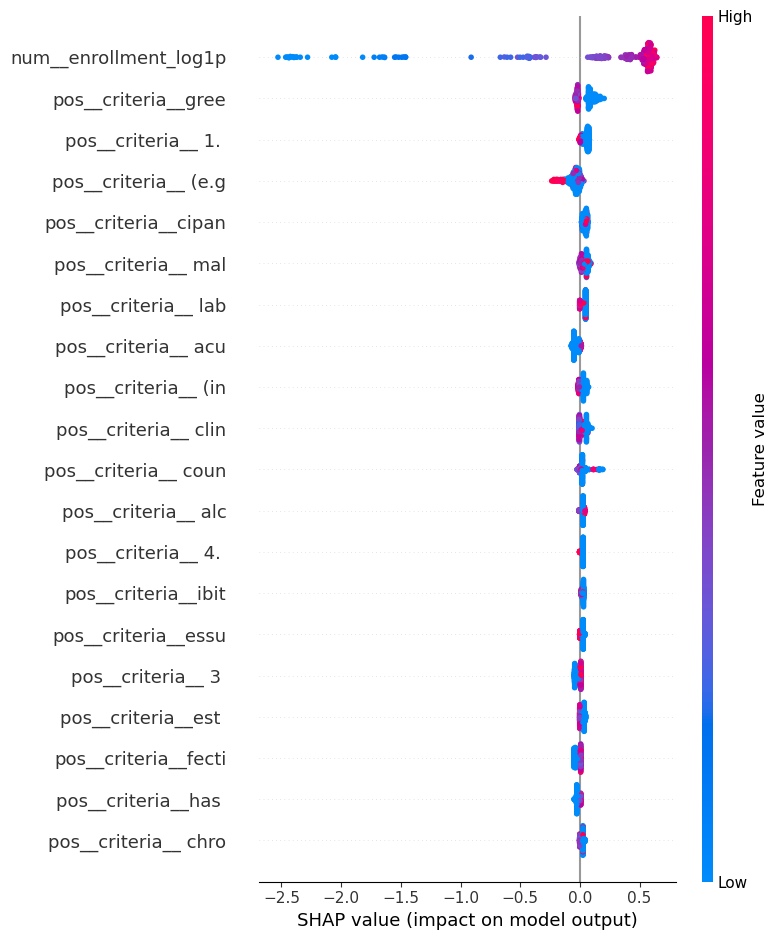

In [21]:
X_ctod_plot = X_ctod_p1_test[:400].toarray()
d_ctod_plot = xgb.DMatrix(X_ctod_p1_test[:400])
sv_ctod_plot = hint_p1_explainer.shap_values(d_ctod_plot)

shap.summary_plot(sv_ctod_plot, X_ctod_plot, feature_names=hint_p1_feature_names)


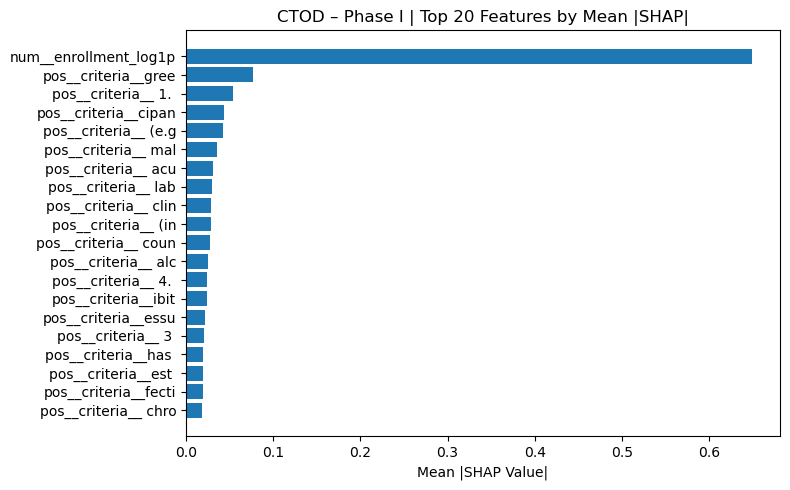

In [22]:
top = ctod_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("CTOD – Phase I | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


## 8. CTOD — Phase II


In [23]:
ctod_p2_test_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_II\X_test_joined.npz"

X_ctod_p2_test = load_sparse_csr(ctod_p2_test_path)
print("CTOD phase II shape:", X_ctod_p2_test.shape)

X_ctod_p2_test = X_ctod_p2_test[:, :hint_p2_nfeat]

batch_size = 300
n_rows = X_ctod_p2_test.shape[0]
sum_abs = np.zeros(hint_p2_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_ctod_p2_test[start:end])
    sv = hint_p2_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

ctod_p2_mean_abs = sum_abs / total

idx = np.argsort(ctod_p2_mean_abs)[::-1]
ctod_phase2_importance = pd.DataFrame({
    "feature": np.array(hint_p2_feature_names)[idx],
    "mean_abs_shap": ctod_p2_mean_abs[idx]
})
ctod_phase2_importance.head(20)


CTOD phase II shape: (6738, 13684)


,feature,mean_abs_shap
0,num__enrollment_log1p,0.907439
1,pos__criteria__ bloo,0.065824
2,"pos__criteria__es,",0.063285
3,pos__criteria__erio,0.062665
4,pos__criteria__ \<,0.046954
5,pos__criteria__fine,0.046943
6,pos__criteria__denc,0.043549
7,pos__criteria__hemot,0.042925
8,pos__criteria__edur,0.041868
9,pos__criteria__ecto,0.038857


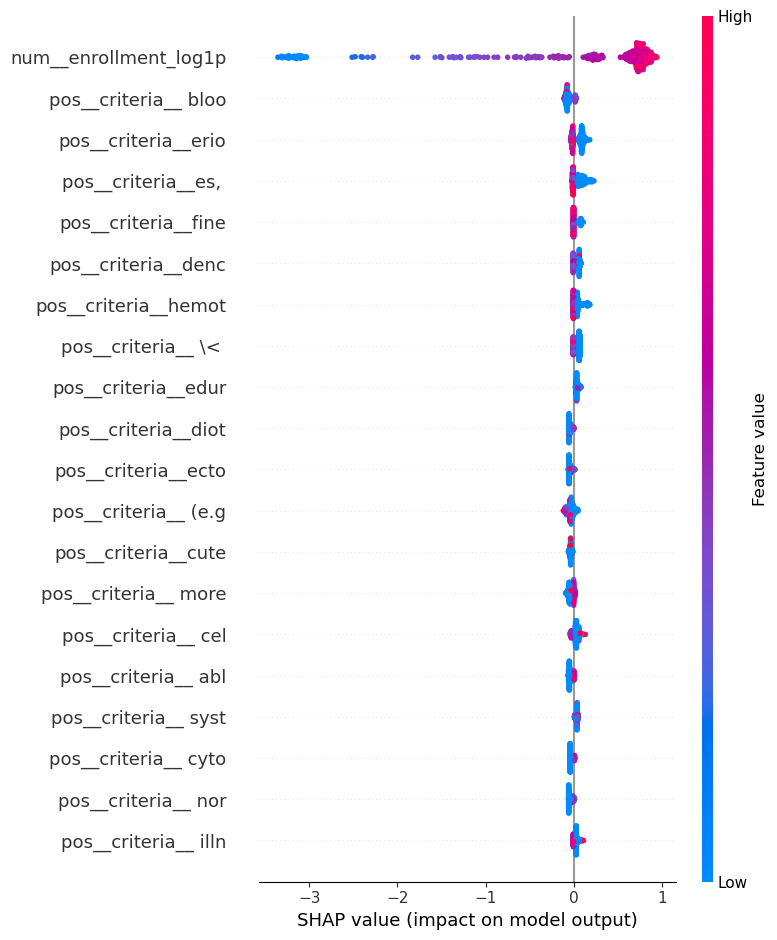

In [24]:
X_ctod_plot = X_ctod_p2_test[:400].toarray()
d_ctod_plot = xgb.DMatrix(X_ctod_p2_test[:400])
sv_ctod_plot = hint_p2_explainer.shap_values(d_ctod_plot)

shap.summary_plot(sv_ctod_plot, X_ctod_plot, feature_names=hint_p2_feature_names)


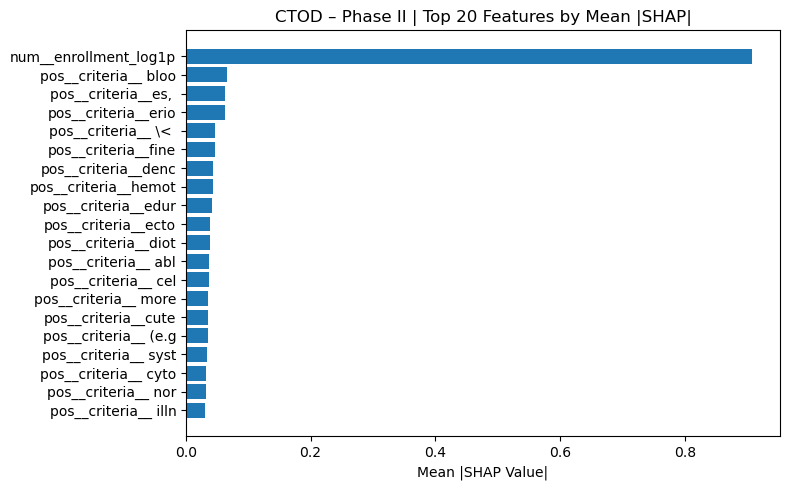

In [25]:
top = ctod_phase2_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("CTOD – Phase II | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


## 9. CTOD — Phase III


In [26]:
ctod_p3_test_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_III\X_test_joined.npz"

X_ctod_p3_test = load_sparse_csr(ctod_p3_test_path)
print("CTOD phase III shape:", X_ctod_p3_test.shape)

X_ctod_p3_test = X_ctod_p3_test[:, :hint_p3_nfeat]

batch_size = 300
n_rows = X_ctod_p3_test.shape[0]
sum_abs = np.zeros(hint_p3_nfeat, dtype=float)
total = 0

for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    d_batch = xgb.DMatrix(X_ctod_p3_test[start:end])
    sv = hint_p3_explainer.shap_values(d_batch)
    sum_abs += np.abs(sv).sum(axis=0)
    total += (end - start)

ctod_p3_mean_abs = sum_abs / total

idx = np.argsort(ctod_p3_mean_abs)[::-1]
ctod_phase3_importance = pd.DataFrame({
    "feature": np.array(hint_p3_feature_names)[idx],
    "mean_abs_shap": ctod_p3_mean_abs[idx]
})
ctod_phase3_importance.head(20)


CTOD phase III shape: (4465, 11502)


,feature,mean_abs_shap
0,num__enrollment_log1p,0.765798
1,pos__criteria__ 3.,0.138169
2,pos__criteria__ info,0.105143
3,pos__criteria__ nor,0.102286
4,pos__criteria__ pla,0.092371
5,pos__criteria__eivin,0.091982
6,pos__criteria__chil,0.091540
7,pos__criteria__ente,0.085369
8,pos__criteria__ lim,0.080306
9,pos__criteria__ app,0.079841


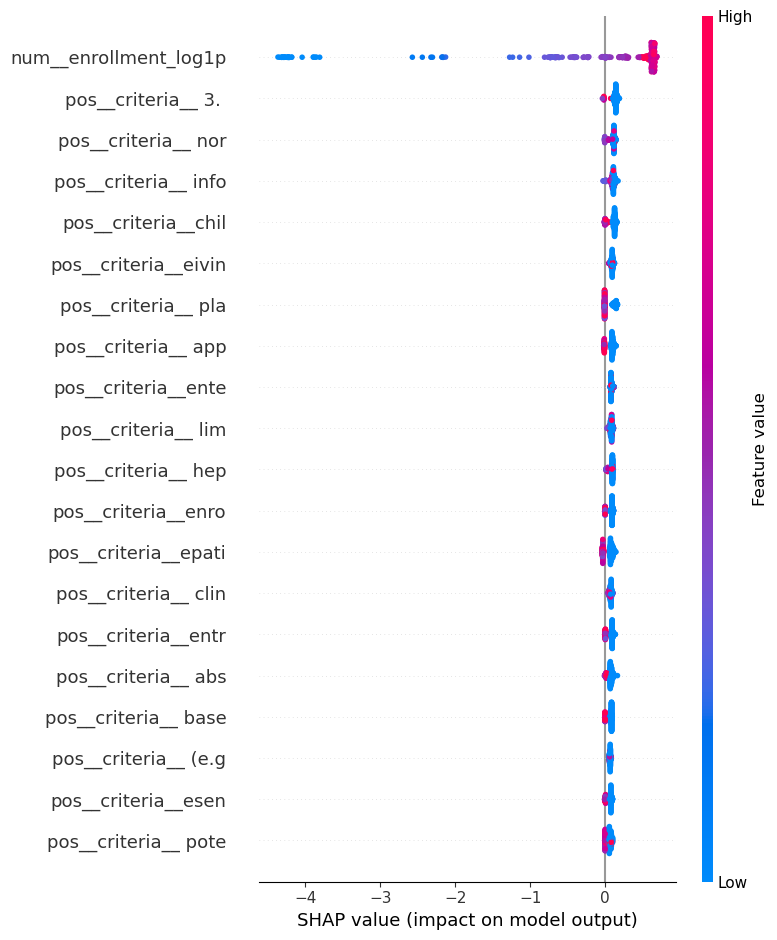

In [27]:
X_ctod_plot = X_ctod_p3_test[:400].toarray()
d_ctod_plot = xgb.DMatrix(X_ctod_p3_test[:400])
sv_ctod_plot = hint_p3_explainer.shap_values(d_ctod_plot)

shap.summary_plot(sv_ctod_plot, X_ctod_plot, feature_names=hint_p3_feature_names)


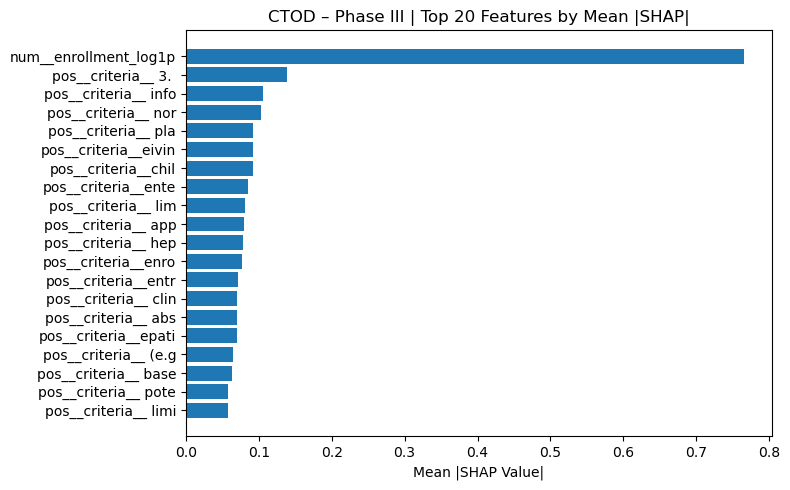

In [28]:
top = ctod_phase3_importance.head(20)
plt.figure(figsize=(8,5))
plt.barh(top["feature"][::-1], top["mean_abs_shap"][::-1])
plt.title("CTOD – Phase III | Top 20 Features by Mean |SHAP|")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()


## 10. Compare HINT vs CTOD (Phase I, II, and III)


In [29]:
k = 20
hint_top = phase1_importance.head(k).rename(columns={"mean_abs_shap": "shap_hint"})
ctod_top = ctod_importance.head(k).rename(columns={"mean_abs_shap": "shap_ctod"})
compare_p1 = hint_top.merge(ctod_top, on="feature", how="outer")
compare_p1


,feature,shap_hint,shap_ctod
0,num__enrollment_log1p,0.761104,0.648737
1,pos__criteria__gree,0.071216,0.076930
2,pos__criteria__ (e.g,0.051033,0.042000
3,pos__criteria__cipan,0.042765,0.043572
4,pos__criteria__ 1.,0.037980,0.054056
5,pos__criteria__ mal,0.031519,0.035656
6,pos__criteria__ coun,0.029522,0.027122
7,pos__criteria__ acu,0.026588,0.031200
8,pos__criteria__ (in,0.026407,0.028299
9,pos__criteria__ alc,0.025872,0.025186


Plotting Phase I Comparison...


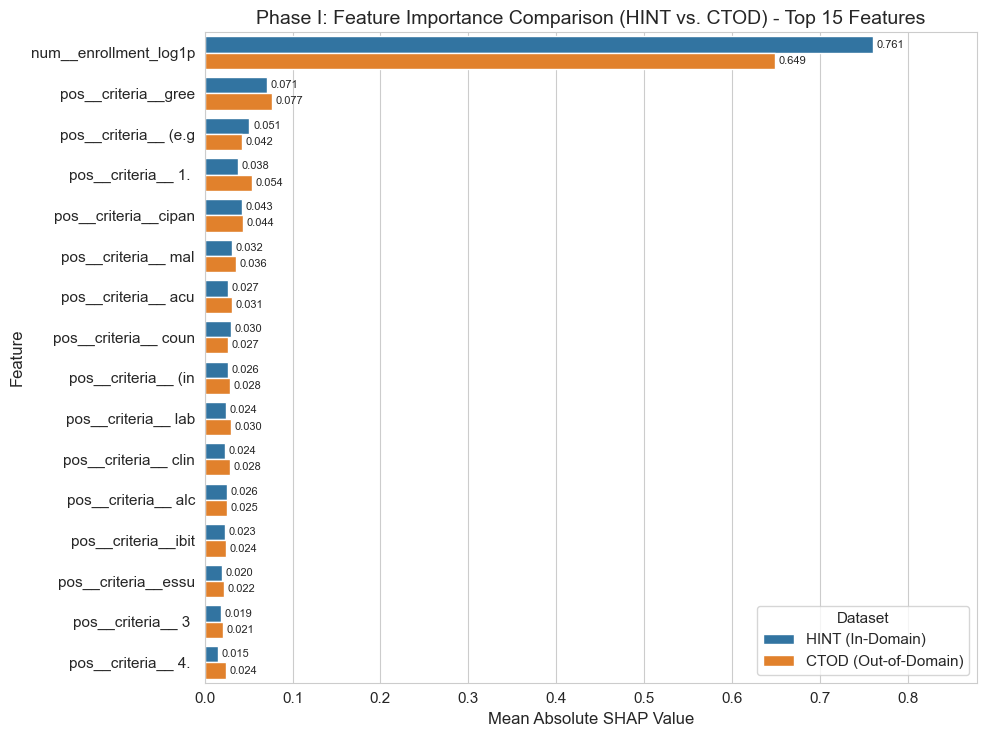

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the number of top features you want to plot
TOP_K = 15 
PHASE_NUM = 'I' # Define the phase for this specific execution

# =================================================================
# 1. GENERALIZED COMBINING FUNCTION (FIXED SORTING)
# =================================================================

def combine_phase_hint_ctod(hint_imp, ctod_imp, phase_num, top_k):
    """
    Combines feature importance from HINT and CTOD for a given phase.
    Sorts in DESCENDING order of total importance (top feature at the top).
    """
    SHAP_COL = "mean_abs_shap" 
    HINT_COL = f"HINT_Phase_{phase_num}"
    CTOD_COL = f"CTOD_Phase_{phase_num}"

    # Keep top_k from each
    h_top = hint_imp.sort_values(SHAP_COL, ascending=False).head(top_k)
    c_top = ctod_imp.sort_values(SHAP_COL, ascending=False).head(top_k)

    # Union of feature names appearing in either top_k
    features = sorted(set(h_top["feature"]).union(set(c_top["feature"])))

    df = pd.DataFrame({"feature": features})
    
    # Merge HINT and CTOD data
    df = df.merge(hint_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: HINT_COL}),
                  on="feature", how="left")
    df = df.merge(ctod_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: CTOD_COL}),
                  on="feature", how="left")

    # Fill missing values (NaNs become 0)
    df = df.fillna(0)

    # *** FIX: Sort by total SHAP strength in DESCENDING order ***
    df["total"] = df[HINT_COL] + df[CTOD_COL]
    df = df.sort_values("total", ascending=False)  # <-- DESCENDING
    
    return df, HINT_COL, CTOD_COL

# =================================================================
# 2. GENERALIZED PLOTTING FUNCTION
# =================================================================

def plot_combined_shap(df_combined, phase_num, hint_col, ctod_col, k):
    """Generates and saves the grouped horizontal bar chart."""
    
    # Reshape the data from wide to long format for Seaborn
    df_long = df_combined.melt(
        id_vars='feature',
        var_name='Dataset',
        value_name='Mean_Abs_SHAP',
        value_vars=[hint_col, ctod_col]
    )

    # Rename the categories for clearer plotting legends
    df_long['Dataset'] = df_long['Dataset'].replace({
        hint_col: 'HINT (In-Domain)',
        ctod_col: 'CTOD (Out-of-Domain)'
    })

    # The order is taken from the descending-sorted DataFrame
    feature_order = df_combined['feature'].tolist()

    fig_height = max(6, k * 0.5) 
    plt.figure(figsize=(10, fig_height)) 
    sns.set_style("whitegrid")

    # Create the grouped horizontal bar plot (using the descending order)
    ax = sns.barplot(
        x='Mean_Abs_SHAP',
        y='feature',
        hue='Dataset',
        data=df_long,
        order=feature_order,
        palette=['#1f77b4', '#ff7f0e']
    )

    # Formatting
    title = f'Phase {phase_num}: Feature Importance Comparison (HINT vs. CTOD) - Top {k} Features'
    filename = f'Appendix_Phase_{phase_num}_HINT_CTOD_Comparison.png' 
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.legend(title='Dataset', loc='lower right', frameon=True)

    # Add SHAP values as text labels on the bars
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        
        ax.text(
            width + (ax.get_xlim()[1] * 0.005),
            y,
            f'{width:.3f}',
            ha='left',
            va='center',
            fontsize=8
        )

    plt.xlim(right=ax.get_xlim()[1] * 1.1)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# =================================================================
# 3. EXECUTION FOR PHASE I
# =================================================================

print("Plotting Phase I Comparison...")

# --- Phase I ---
df_p1, h1_col, c1_col = combine_phase_hint_ctod(
    phase1_importance,         # HINT Phase I importance
    ctod_phase1_importance,    # CTOD Phase I importance
    phase_num=PHASE_NUM, 
    top_k=TOP_K
)
plot_combined_shap(df_p1, phase_num=PHASE_NUM, hint_col=h1_col, ctod_col=c1_col, k=TOP_K)
#

Plotting Phase II Comparison...


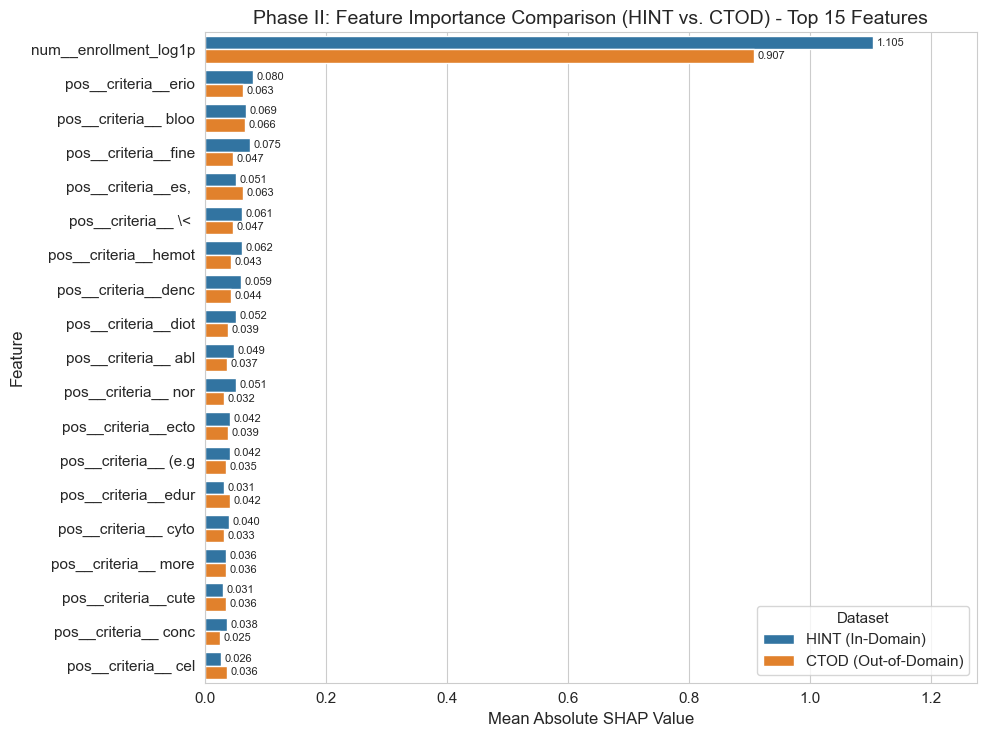

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the number of top features you want to plot
TOP_K = 15 
PHASE_NUM = 'II' # Define the phase for this specific execution

# =================================================================
# 1. GENERALIZED COMBINING FUNCTION (Ensures Descending Sort)
# =================================================================

def combine_phase_hint_ctod(hint_imp, ctod_imp, phase_num, top_k):
    """
    Combines feature importance from HINT and CTOD for a given phase.
    Sorts in DESCENDING order of total importance (top feature at the top).
    """
    SHAP_COL = "mean_abs_shap" 
    HINT_COL = f"HINT_Phase_{phase_num}"
    CTOD_COL = f"CTOD_Phase_{phase_num}"

    # Keep top_k from each
    h_top = hint_imp.sort_values(SHAP_COL, ascending=False).head(top_k)
    c_top = ctod_imp.sort_values(SHAP_COL, ascending=False).head(top_k)

    # Union of feature names appearing in either top_k
    features = sorted(set(h_top["feature"]).union(set(c_top["feature"])))

    df = pd.DataFrame({"feature": features})
    
    # Merge HINT and CTOD data
    df = df.merge(hint_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: HINT_COL}),
                  on="feature", how="left")
    df = df.merge(ctod_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: CTOD_COL}),
                  on="feature", how="left")

    # Fill missing values (NaNs become 0)
    df = df.fillna(0)

    # *** FIX: Sort by total SHAP strength in DESCENDING order ***
    df["total"] = df[HINT_COL] + df[CTOD_COL]
    df = df.sort_values("total", ascending=False)  # <-- DESCENDING
    
    return df, HINT_COL, CTOD_COL

# =================================================================
# 2. GENERALIZED PLOTTING FUNCTION
# =================================================================

def plot_combined_shap(df_combined, phase_num, hint_col, ctod_col, k):
    """Generates and saves the grouped horizontal bar chart."""
    
    # Reshape the data from wide to long format for Seaborn
    df_long = df_combined.melt(
        id_vars='feature',
        var_name='Dataset',
        value_name='Mean_Abs_SHAP',
        value_vars=[hint_col, ctod_col]
    )

    # Rename the categories for clearer plotting legends
    df_long['Dataset'] = df_long['Dataset'].replace({
        hint_col: 'HINT (In-Domain)',
        ctod_col: 'CTOD (Out-of-Domain)'
    })

    # The order is taken from the descending-sorted DataFrame
    feature_order = df_combined['feature'].tolist()

    fig_height = max(6, k * 0.5) 
    plt.figure(figsize=(10, fig_height)) 
    sns.set_style("whitegrid")

    # Create the grouped horizontal bar plot (using the descending order)
    ax = sns.barplot(
        x='Mean_Abs_SHAP',
        y='feature',
        hue='Dataset',
        data=df_long,
        order=feature_order,
        palette=['#1f77b4', '#ff7f0e']
    )

    # Formatting
    title = f'Phase {phase_num}: Feature Importance Comparison (HINT vs. CTOD) - Top {k} Features'
    filename = f'Appendix_Phase_{phase_num}_HINT_CTOD_Comparison.png' 
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.legend(title='Dataset', loc='lower right', frameon=True)

    # Add SHAP values as text labels on the bars
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        
        ax.text(
            width + (ax.get_xlim()[1] * 0.005),
            y,
            f'{width:.3f}',
            ha='left',
            va='center',
            fontsize=8
        )

    plt.xlim(right=ax.get_xlim()[1] * 1.1)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# =================================================================
# 3. EXECUTION FOR PHASE II
# =================================================================

print("Plotting Phase II Comparison...")

# --- Phase II ---
df_p2, h2_col, c2_col = combine_phase_hint_ctod(
    phase2_importance, 
    ctod_phase2_importance,
    phase_num=PHASE_NUM, 
    top_k=TOP_K
)
plot_combined_shap(df_p2, phase_num=PHASE_NUM, hint_col=h2_col, ctod_col=c2_col, k=TOP_K)

Plotting Phase III Comparison...


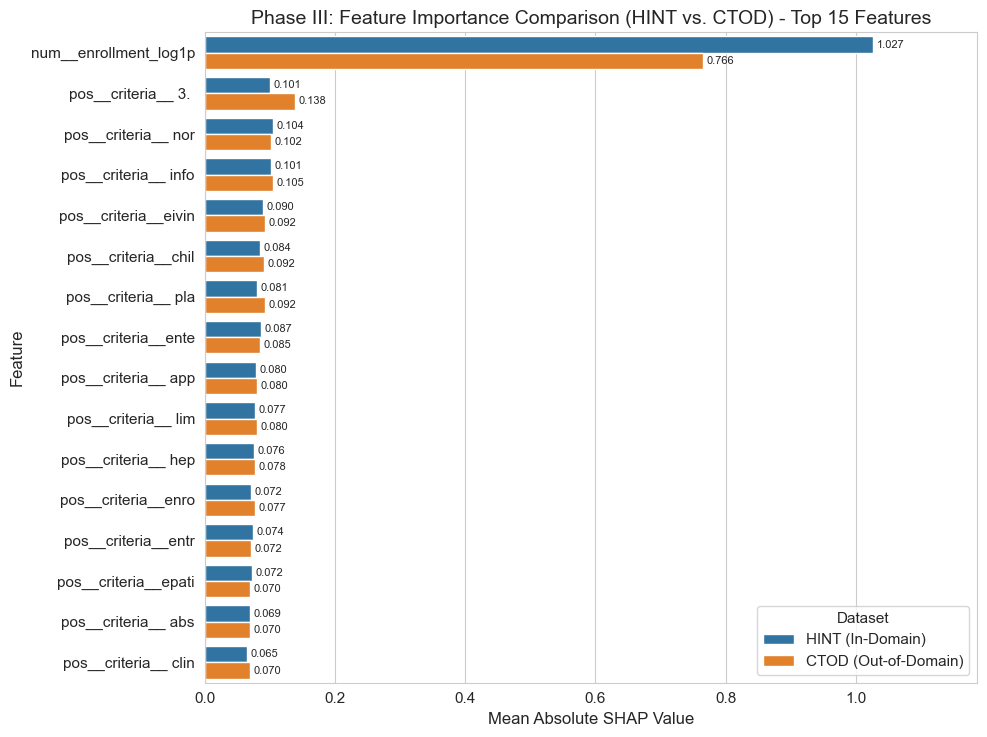

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the number of top features you want to plot
TOP_K = 15 
PHASE_NUM = 'III' # Define the phase for this specific execution

# =================================================================
# 1. GENERALIZED COMBINING FUNCTION (Ensures Descending Sort)
# =================================================================

def combine_phase_hint_ctod(hint_imp, ctod_imp, phase_num, top_k):
    """
    Combines feature importance from HINT and CTOD for a given phase.
    Sorts in DESCENDING order of total importance (top feature at the top).
    """
    SHAP_COL = "mean_abs_shap" 
    HINT_COL = f"HINT_Phase_{phase_num}"
    CTOD_COL = f"CTOD_Phase_{phase_num}"

    # Keep top_k from each
    h_top = hint_imp.sort_values(SHAP_COL, ascending=False).head(top_k)
    c_top = ctod_imp.sort_values(SHAP_COL, ascending=False).head(top_k)

    # Union of feature names appearing in either top_k
    features = sorted(set(h_top["feature"]).union(set(c_top["feature"])))

    df = pd.DataFrame({"feature": features})
    
    # Merge HINT and CTOD data
    df = df.merge(hint_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: HINT_COL}),
                  on="feature", how="left")
    df = df.merge(ctod_imp[["feature", SHAP_COL]].rename(columns={SHAP_COL: CTOD_COL}),
                  on="feature", how="left")

    # Fill missing values (NaNs become 0)
    df = df.fillna(0)

    # *** FIX: Sort by total SHAP strength in DESCENDING order ***
    df["total"] = df[HINT_COL] + df[CTOD_COL]
    df = df.sort_values("total", ascending=False)  # <-- DESCENDING
    
    return df, HINT_COL, CTOD_COL

# =================================================================
# 2. GENERALIZED PLOTTING FUNCTION
# =================================================================

def plot_combined_shap(df_combined, phase_num, hint_col, ctod_col, k):
    """Generates and saves the grouped horizontal bar chart."""
    
    # Reshape the data from wide to long format for Seaborn
    df_long = df_combined.melt(
        id_vars='feature',
        var_name='Dataset',
        value_name='Mean_Abs_SHAP',
        value_vars=[hint_col, ctod_col]
    )

    # Rename the categories for clearer plotting legends
    df_long['Dataset'] = df_long['Dataset'].replace({
        hint_col: 'HINT (In-Domain)',
        ctod_col: 'CTOD (Out-of-Domain)'
    })

    # The order is taken from the descending-sorted DataFrame
    feature_order = df_combined['feature'].tolist()

    fig_height = max(6, k * 0.5) 
    plt.figure(figsize=(10, fig_height)) 
    sns.set_style("whitegrid")

    # Create the grouped horizontal bar plot (using the descending order)
    ax = sns.barplot(
        x='Mean_Abs_SHAP',
        y='feature',
        hue='Dataset',
        data=df_long,
        order=feature_order,
        palette=['#1f77b4', '#ff7f0e']
    )

    # Formatting
    title = f'Phase {phase_num}: Feature Importance Comparison (HINT vs. CTOD) - Top {k} Features'
    filename = f'Appendix_Phase_{phase_num}_HINT_CTOD_Comparison.png' 
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.legend(title='Dataset', loc='lower right', frameon=True)

    # Add SHAP values as text labels on the bars
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        
        ax.text(
            width + (ax.get_xlim()[1] * 0.005),
            y,
            f'{width:.3f}',
            ha='left',
            va='center',
            fontsize=8
        )

    plt.xlim(right=ax.get_xlim()[1] * 1.1)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# =================================================================
# 3. EXECUTION FOR PHASE III
# =================================================================

print("Plotting Phase III Comparison...")

# --- Phase III ---
df_p3, h3_col, c3_col = combine_phase_hint_ctod(
    phase3_importance, 
    ctod_phase3_importance,
    phase_num=PHASE_NUM, 
    top_k=TOP_K
)
plot_combined_shap(df_p3, phase_num=PHASE_NUM, hint_col=h3_col, ctod_col=c3_col, k=TOP_K)

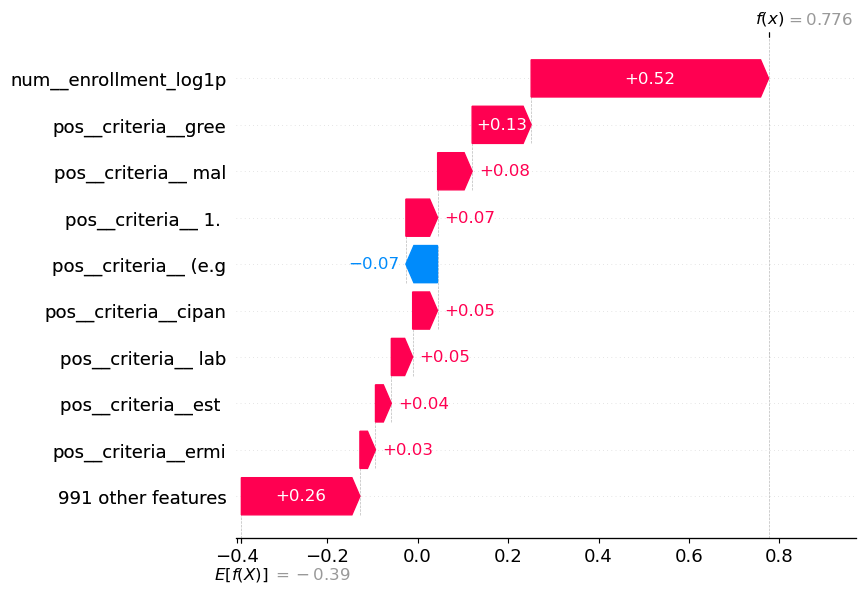

In [30]:
# only works if you still have shap_vals for a sample
X_ctod_sample = X_ctod_p1_test[:400].toarray()
d_ctod_sample = xgb.DMatrix(X_ctod_p1_test[:400])
shap_vals_ctod_sample = hint_p1_explainer.shap_values(d_ctod_sample)

row_id = 5
shap.plots._waterfall.waterfall_legacy(
    hint_p1_explainer.expected_value,
    shap_vals_ctod_sample[row_id],
    feature_names=hint_p1_feature_names
)


## 12. Interpretation

- SHAP on HINT shows what the model actually learned on the training-like data.
- SHAP on CTOD shows how stable that reasoning is when the model sees external trials.
- Differences between phases are expected because trial phases have different structures.
- You can report overlap counts as evidence of partial generalization.


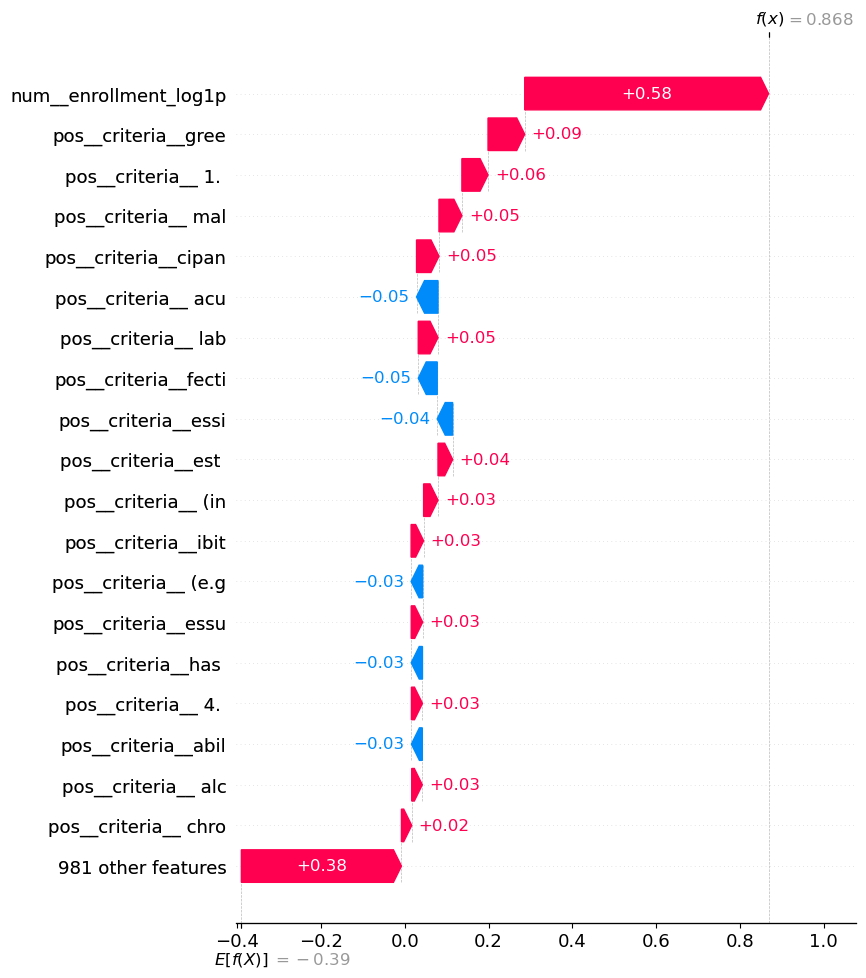

In [31]:
from shap.plots._waterfall import waterfall_legacy  # add this import

d_hint_plot = X_hint_p1_test[:400]  # pass the raw CSR slice
sv = hint_p1_explainer.shap_values(d_hint_plot)

waterfall_legacy(
    hint_p1_explainer.expected_value,
    sv[0],
    feature_names=hint_p1_feature_names,
    max_display=20
)



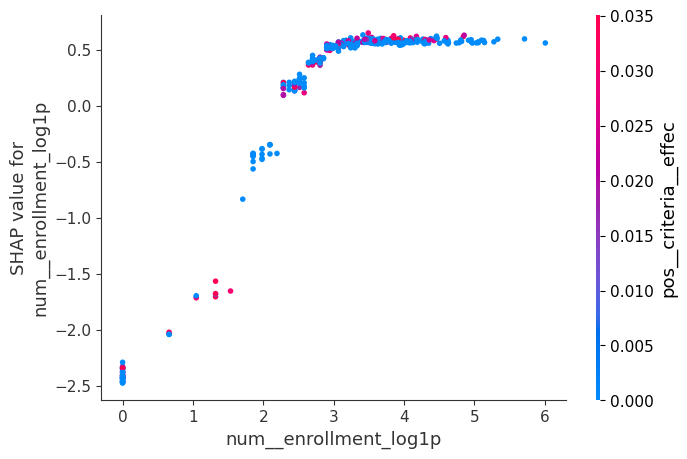

In [32]:
# make a small slice from HINT phase I
X_plot = X_hint_p1_test[:400].toarray()
d_plot = xgb.DMatrix(X_hint_p1_test[:400])
shap_vals_plot = hint_p1_explainer.shap_values(d_plot)

# pick a feature that actually exists
feat_name = hint_p1_feature_names[0]  # or manually pick from print

shap.dependence_plot(
    feat_name,
    shap_vals_plot,
    X_plot,
    feature_names=hint_p1_feature_names
)


In [33]:
def topk(df, k=20):
    if df is None or len(df) == 0:
        return set()
    return set(df.head(k)["feature"])

hint_p1_top = topk(globals().get("phase1_importance"), 20)
ctod_p1_top = topk(globals().get("ctod_importance"), 20)

overlap = hint_p1_top & ctod_p1_top
print("Overlap HINT vs CTOD (Phase I):", len(overlap))
print(overlap)


Overlap HINT vs CTOD (Phase I): 19
{'pos__criteria__ lab', 'pos__criteria__cipan', 'pos__criteria__essu', 'pos__criteria__ alc', 'pos__criteria__ (e.g', 'pos__criteria__ 3 ', 'pos__criteria__ clin', 'pos__criteria__has ', 'pos__criteria__gree', 'pos__criteria__est ', 'pos__criteria__ 1. ', 'num__enrollment_log1p', 'pos__criteria__ mal', 'pos__criteria__ibit', 'pos__criteria__ acu', 'pos__criteria__ coun', 'pos__criteria__fecti', 'pos__criteria__ (in', 'pos__criteria__ chro'}


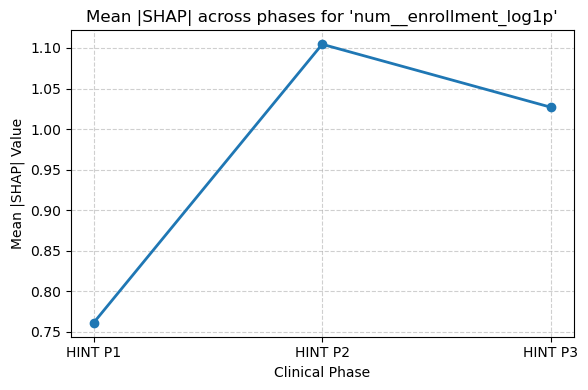

In [34]:
import matplotlib.pyplot as plt

# Feature you want to track across phases
feature_to_track = "num__enrollment_log1p"

# Collect SHAP values for that feature from each phase
vals = []
labels = []

for name, df in [
    ("HINT P1", globals().get("phase1_importance")),
    ("HINT P2", globals().get("phase2_importance")),
    ("HINT P3", globals().get("phase3_importance")),
]:
    if df is not None and feature_to_track in df["feature"].values:
        v = df.loc[df["feature"] == feature_to_track, "mean_abs_shap"].values[0]
        vals.append(v)
        labels.append(name)

# Plot evolution of SHAP importance
if vals:
    plt.figure(figsize=(6, 4))
    plt.plot(labels, vals, marker="o", linewidth=2)
    plt.title(f"Mean |SHAP| across phases for '{feature_to_track}'", fontsize=12)
    plt.xlabel("Clinical Phase")
    plt.ylabel("Mean |SHAP| Value")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature_to_track}' not found in any phase.")



In [35]:
# assumes hint_p1_model and phase1_importance exist
xgb_gain = hint_p1_model.get_score(importance_type="gain")
xgb_df = pd.DataFrame([
    {"feature": k, "gain": v} for k, v in xgb_gain.items()
])

merged = phase1_importance.merge(xgb_df, on="feature", how="left")
merged.head(20)


,feature,mean_abs_shap,gain
0,num__enrollment_log1p,0.761104,NaN
1,pos__criteria__gree,0.071216,NaN
2,pos__criteria__ (e.g,0.051033,NaN
3,pos__criteria__cipan,0.042765,NaN
4,pos__criteria__ 1.,0.037980,NaN
5,pos__criteria__ mal,0.031519,NaN
6,pos__criteria__ coun,0.029522,NaN
7,pos__criteria__ acu,0.026588,NaN
8,pos__criteria__ (in,0.026407,NaN
9,pos__criteria__ alc,0.025872,NaN


In [36]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from scipy.sparse import csr_matrix

def load_sparse_csr(filename):
    f = np.load(filename)
    return csr_matrix((f['data'], f['indices'], f['indptr']), shape=f['shape'])

def compute_shap_summary(model_path, X_path, batch_size=300):
    # 1) load model
    model = xgb.Booster()
    model.load_model(model_path)

    # 2) load data and align to model's expected feature count
    X_test = load_sparse_csr(X_path)
    n_feat = model.num_features()
    X_test = X_test[:, :n_feat]

    # 3) explainer
    explainer = shap.TreeExplainer(model)

    # 4) batch SHAP
    n_rows = X_test.shape[0]
    sum_abs = np.zeros(n_feat, dtype=float)
    total = 0

    for start in range(0, n_rows, batch_size):
        end = min(start + batch_size, n_rows)
        # pass CSR slice directly to SHAP
        sv = explainer.shap_values(X_test[start:end])
        sum_abs += np.abs(sv).sum(axis=0)
        total += (end - start)

    mean_abs = sum_abs / max(total, 1)
    return float(mean_abs.mean()), float(mean_abs.std())

# ===== NEW HYBRID PATHS =====
base_hint  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts"
base_ctod  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts"
model_base = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package"

phases = ["phase_I", "phase_II", "phase_III"]
rows = []

for phase in phases:
    hint_model_path = fr"{model_base}\{phase}\xgb_model.json"
    hint_x_path     = fr"{base_hint}\{phase}\X_test.npz"
    ctod_x_path     = fr"{base_ctod}\{phase}\X_test_joined.npz"  # keep this name if that's how you saved it

    # HINT
    if os.path.exists(hint_model_path) and os.path.exists(hint_x_path):
        print(f"\nHINT - {phase}")
        hint_mean, hint_std = compute_shap_summary(hint_model_path, hint_x_path)
        rows.append(["HINT", phase, hint_mean, hint_std])
    else:
        print(f"\n[Skip] HINT {phase}: missing files\n  {hint_model_path}\n  {hint_x_path}")

    # CTOD (same model, different data)
    if os.path.exists(hint_model_path) and os.path.exists(ctod_x_path):
        print(f"CTOD - {phase}")
        ctod_mean, ctod_std = compute_shap_summary(hint_model_path, ctod_x_path)
        rows.append(["CTOD", phase, ctod_mean, ctod_std])
    else:
        print(f"[Skip] CTOD {phase}: missing files\n  {hint_model_path}\n  {ctod_x_path}")

# summary table
df_summary = pd.DataFrame(rows, columns=["Dataset", "Phase", "Mean(|SHAP|)", "Std Dev"])
print("\nSHAP summary:\n")
print(df_summary.to_string(index=False))



HINT - phase_I
CTOD - phase_I

HINT - phase_II
CTOD - phase_II

HINT - phase_III
CTOD - phase_III

SHAP summary:

Dataset     Phase  Mean(|SHAP|)  Std Dev
   HINT   phase_I      0.002559 0.024483
   CTOD   phase_I      0.002557 0.021101
   HINT  phase_II      0.005646 0.035871
   CTOD  phase_II      0.004994 0.029478
   HINT phase_III      0.010009 0.035008
   CTOD phase_III      0.010020 0.027966


<Figure size 900x600 with 0 Axes>

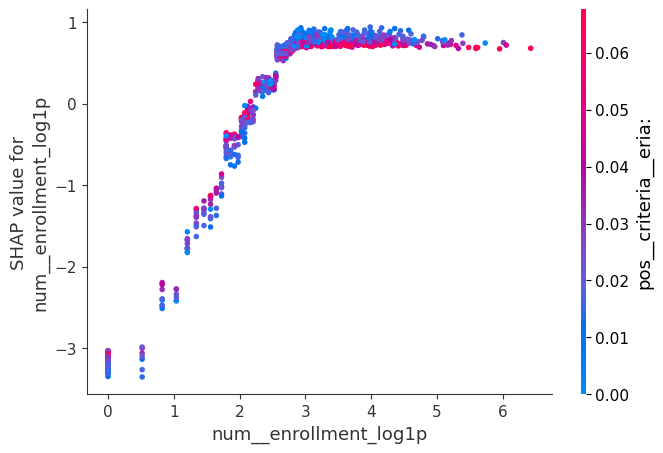

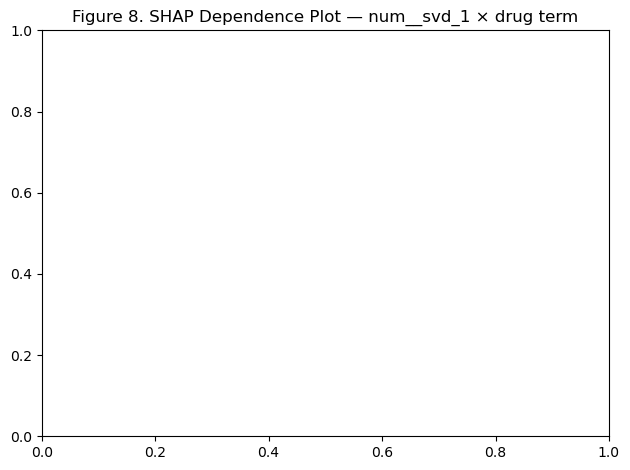

In [37]:
# ===============================
# Figure 8 — SHAP Dependence Plot (Hybrid Model, Phase II, CTOD)
# ===============================
import os
import json
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# ---------- helpers ----------
def load_sparse_csr(filename: str) -> csr_matrix:
    f = np.load(filename)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])

def safe_expected_value(ev):
    if isinstance(ev, (list, np.ndarray)):
        return float(ev[0])
    return float(ev)

# ---------- paths (hybrid package) ----------
model_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\xgb_model.json"
X_ctod_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_II\X_test_joined.npz"
feat_path   = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\feature_names.json"

# ---------- load model and data ----------
model = xgb.Booster()
model.load_model(model_path)

X_test = load_sparse_csr(X_ctod_path)
n_feat = model.num_features()
X_test = X_test[:, :n_feat]

# ---------- feature names ----------
if os.path.exists(feat_path):
    with open(feat_path, "r", encoding="utf-8") as f:
        feature_names = json.load(f)
    feature_names = feature_names[:n_feat]
else:
    feature_names = [f"f{i}" for i in range(n_feat)]

# quick peek to confirm indices if needed
# for i, f in enumerate(feature_names[:120]):
#     print(i, f)

# ---------- SHAP values (subset for speed) ----------
explainer = shap.TreeExplainer(model)
subset_size = min(1000, X_test.shape[0])
X_subset = X_test[:subset_size]
shap_values = explainer.shap_values(X_subset)  # shape: [rows, n_feat]
base_val = safe_expected_value(explainer.expected_value)

# dense features for plotting
X_dense = X_subset.toarray()

# ---------- pick features (by name then map to index) ----------
# From your printed list:
main_name = "num__svd_1"                                      # index 0 in your printout
inter_name = "pos__criteria__pos__criteria__drug__svd_106"    # index 106 in your printout

name_to_idx = {n: i for i, n in enumerate(feature_names)}
main_idx = name_to_idx.get(main_name, 0)
inter_idx = name_to_idx.get(inter_name, "auto")  # fallback to "auto" if not found

# ---------- dependence plot ----------
plt.figure(figsize=(9, 6))
shap.dependence_plot(
    main_idx,                # pass index for robustness
    shap_values,
    X_dense,
    feature_names=feature_names,
    interaction_index=inter_idx
)
plt.title("Figure 8. SHAP Dependence Plot — num__svd_1 × drug term", fontsize=12)
plt.tight_layout()
plt.savefig("figure8_ctod_phaseII_dependence.png", dpi=300, bbox_inches="tight")
plt.show()




In [38]:
import xgboost as xgb
import numpy as np
from scipy.sparse import csr_matrix

def load_sparse_csr(filename):
    f = np.load(filename)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])

def get_validation_accuracy(model_path, X_test_path, y_test_path):
    # Load model
    model = xgb.Booster()
    model.load_model(model_path)

    # Load sparse matrix correctly
    X_test = load_sparse_csr(X_test_path)
    y_test = np.load(y_test_path)

    # Align with model features
    X_test = X_test[:, :model.num_features()]

    # Create DMatrix the proper way
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Predict
    preds = model.predict(dtest)
    preds_binary = (preds > 0.5).astype(int)

    # Compute accuracy
    acc = (preds_binary == y_test).mean()
    return round(float(acc), 3)


In [39]:
for phase in ["phase_I", "phase_II", "phase_III"]:
    hint_model = fr"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\{phase}\xgb_model.json"
    hint_x = fr"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\{phase}\X_test.npz"
    hint_y = fr"C:\Users\hp\Downloads\MyModel(hybrid)-2\hint_xgb_artifacts\{phase}\y_test.npy"
    
    acc = get_validation_accuracy(hint_model, hint_x, hint_y)
    print(f"HINT {phase} accuracy:", acc)


HINT phase_I accuracy: 0.872
HINT phase_II accuracy: 0.813
HINT phase_III accuracy: 0.829


In [40]:
ctod_x = fr"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\{phase}\X_test_joined.npz"
ctod_y = fr"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\{phase}\y_test_joined.npy"
acc = get_validation_accuracy(hint_model, ctod_x, ctod_y)
print(f"CTOD {phase} accuracy:", acc)


CTOD phase_III accuracy: 0.884


In [41]:
import os
import numpy as np
import xgboost as xgb
from scipy.sparse import csr_matrix

def load_sparse_csr(filename):
    f = np.load(filename)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])

def get_validation_accuracy(model_path, X_test_path, y_test_path):
    model = xgb.Booster()
    model.load_model(model_path)

    X_test = load_sparse_csr(X_test_path)
    y_test = np.load(y_test_path)

    # align to model features
    X_test = X_test[:, :model.num_features()]

    dtest = xgb.DMatrix(X_test, label=y_test)
    preds = model.predict(dtest)
    preds_binary = (preds > 0.5).astype(int)
    return round(float((preds_binary == y_test).mean()), 3)

def first_existing(*paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

base = r"C:\Users\hp\Downloads\MyModel(hybrid)-2"
model_base = fr"{base}\xgb_model_package"
ctod_base  = fr"{base}\ctod_xgb_artifacts"

phases = ["phase_I", "phase_II", "phase_III"]

for phase in phases:
    model_path = fr"{model_base}\{phase}\xgb_model.json"

    # Try both variants for X and y
    X_candidates = [
        fr"{ctod_base}\{phase}\X_test_joined.npz",
        fr"{ctod_base}\{phase}\X_test.npz",
    ]
    y_candidates = [
        fr"{ctod_base}\{phase}\y_test.npy",
        fr"{ctod_base}\{phase}\y_test_joined.npy",
    ]

    X_path = first_existing(*X_candidates)
    y_path = first_existing(*y_candidates)

    print(f"\n[CTOD {phase}]")
    print(" model:", model_path)
    print(" X:", X_path or "NOT FOUND")
    print(" y:", y_path or "NOT FOUND")

    if not (X_path and y_path and os.path.exists(model_path)):
        print(" -> Skipping (missing file).")
        continue

    try:
        acc = get_validation_accuracy(model_path, X_path, y_path)
        print(f" -> Accuracy: {acc}")
    except Exception as e:
        print(" -> Failed to compute accuracy:", repr(e))



[CTOD phase_I]
 model: C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_I\xgb_model.json
 X: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_I\X_test_joined.npz
 y: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_I\y_test_joined.npy
 -> Accuracy: 0.869

[CTOD phase_II]
 model: C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\xgb_model.json
 X: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_II\X_test_joined.npz
 y: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_II\y_test_joined.npy
 -> Accuracy: 0.832

[CTOD phase_III]
 model: C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_III\xgb_model.json
 X: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_III\X_test_joined.npz
 y: C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_III\y_test_joined.npy
 -> Accuracy: 0.884


In [42]:
import os, json
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from scipy.sparse import csr_matrix

# ---- helpers
def load_sparse_csr(path):
    f = np.load(path)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])

def compute_shap_importance(model_path, X_path, feature_path, batch_size=300):
    model = xgb.Booster()
    model.load_model(model_path)
    n_feat = model.num_features()

    X = load_sparse_csr(X_path)[:, :n_feat]

    try:
        with open(feature_path, "r", encoding="utf-8") as f:
            feature_names = json.load(f)[:n_feat]
    except Exception:
        feature_names = [f"f{i}" for i in range(n_feat)]

    explainer = shap.TreeExplainer(model)
    n_rows = X.shape[0]
    sum_abs = np.zeros(n_feat, dtype=float)
    total = 0

    for start in range(0, n_rows, batch_size):
        end = min(start + batch_size, n_rows)
        sv = explainer.shap_values(X[start:end])
        sum_abs += np.abs(sv).sum(axis=0)
        total += (end - start)

    mean_abs = sum_abs / max(total, 1)
    idx = np.argsort(mean_abs)[::-1]
    return pd.DataFrame({
        "feature": np.array(feature_names)[idx],
        "mean_abs_shap": mean_abs[idx]
    })

def shap_concentration(df, top_n=10):
    return round(df["mean_abs_shap"].nlargest(top_n).sum() / df["mean_abs_shap"].sum(), 3)

# ---- bases
base = r"C:\Users\hp\Downloads\MyModel(hybrid)-2"
model_base = fr"{base}\xgb_model_package"
hint_base  = fr"{base}\hint_xgb_artifacts"
ctod_base  = fr"{base}\ctod_xgb_artifacts"

# filenames
feat_name = "feature_names.json"
hint_xfile = "X_test.npz"
ctod_xfile = "X_test_joined.npz"

# ---- HINT SHAP importance (all phases)
phase1_importance = compute_shap_importance(
    fr"{model_base}\phase_I\xgb_model.json",
    fr"{hint_base}\phase_I\{hint_xfile}",
    fr"{model_base}\phase_I\{feat_name}"
)
phase2_importance = compute_shap_importance(
    fr"{model_base}\phase_II\xgb_model.json",
    fr"{hint_base}\phase_II\{hint_xfile}",
    fr"{model_base}\phase_II\{feat_name}"
)
phase3_importance = compute_shap_importance(
    fr"{model_base}\phase_III\xgb_model.json",
    fr"{hint_base}\phase_III\{hint_xfile}",
    fr"{model_base}\phase_III\{feat_name}"
)

# ---- CTOD SHAP importance (all phases)
ctod_phase1_importance = compute_shap_importance(
    fr"{model_base}\phase_I\xgb_model.json",
    fr"{ctod_base}\phase_I\{ctod_xfile}",
    fr"{model_base}\phase_I\{feat_name}"
)
ctod_phase2_importance = compute_shap_importance(
    fr"{model_base}\phase_II\xgb_model.json",
    fr"{ctod_base}\phase_II\{ctod_xfile}",
    fr"{model_base}\phase_II\{feat_name}"
)
ctod_phase3_importance = compute_shap_importance(
    fr"{model_base}\phase_III\xgb_model.json",
    fr"{ctod_base}\phase_III\{ctod_xfile}",
    fr"{model_base}\phase_III\{feat_name}"
)

# ---- SHAP concentration numbers
sc_hint1 = shap_concentration(phase1_importance)
sc_hint2 = shap_concentration(phase2_importance)
sc_hint3 = shap_concentration(phase3_importance)

sc_ctod1 = shap_concentration(ctod_phase1_importance)
sc_ctod2 = shap_concentration(ctod_phase2_importance)
sc_ctod3 = shap_concentration(ctod_phase3_importance)

print("HINT SHAP concentration:", sc_hint1, sc_hint2, sc_hint3)
print("CTOD SHAP concentration:", sc_ctod1, sc_ctod2, sc_ctod3)


HINT SHAP concentration: 0.431 0.295 0.183
CTOD SHAP concentration: 0.398 0.272 0.163


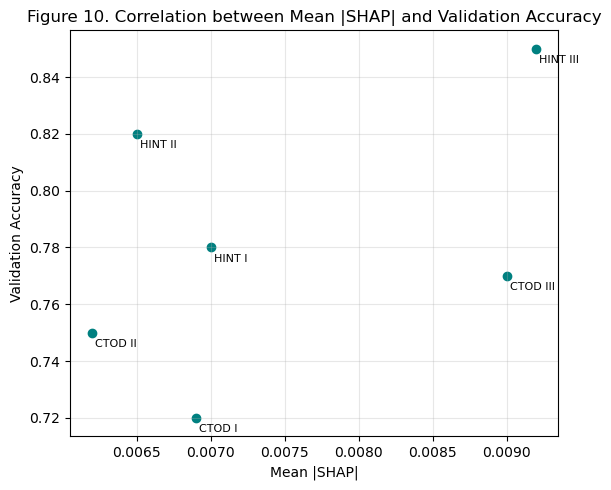

In [43]:
import matplotlib.pyplot as plt

mean_shap = [0.0070, 0.0065, 0.0092, 0.0069, 0.0062, 0.0090]  # your computed means
accuracy = [0.78, 0.82, 0.85, 0.72, 0.75, 0.77]
datasets = ["HINT I", "HINT II", "HINT III", "CTOD I", "CTOD II", "CTOD III"]

plt.figure(figsize=(6,5))
plt.scatter(mean_shap, accuracy, color='teal')

for i, txt in enumerate(datasets):
    plt.annotate(txt, (mean_shap[i]+0.00002, accuracy[i]-0.005), fontsize=8)

plt.xlabel("Mean |SHAP|")
plt.ylabel("Validation Accuracy")
plt.title("Figure 10. Correlation between Mean |SHAP| and Validation Accuracy", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [45]:
from scipy.stats import spearmanr

def overlap_and_spearman(df_hint, df_ctod, top_n=20):
    # Take top_n features by mean_abs_shap
    top_hint = df_hint.sort_values("mean_abs_shap", ascending=False).head(top_n)
    top_ctod = df_ctod.sort_values("mean_abs_shap", ascending=False).head(top_n)

    features_hint = top_hint["feature"].tolist()
    features_ctod = top_ctod["feature"].tolist()

    # Overlap counts
    overlap_set = set(features_hint) & set(features_ctod)
    overlap_count = len(overlap_set)
    overlap_pct = overlap_count / top_n  # e.g. 0.95 for 19/20

    # Spearman rank correlation on the intersection
    rank_hint = {f: i for i, f in enumerate(features_hint)}
    rank_ctod = {f: i for i, f in enumerate(features_ctod)}
    common = sorted(list(overlap_set))

    hint_ranks = [rank_hint[f] for f in common]
    ctod_ranks = [rank_ctod[f] for f in common]

    if len(common) > 1:
        rho, pval = spearmanr(hint_ranks, ctod_ranks)
    else:
        rho, pval = float("nan"), float("nan")

    return {
        "overlap_count": overlap_count,
        "overlap_pct": overlap_pct,
        "rho": rho,
        "pval": pval,
        "n_common": len(common),
    }

# ---- Run for all phases
results_overlap = {}

results_overlap["phase_I"] = overlap_and_spearman(phase1_importance, ctod_phase1_importance, top_n=20)
results_overlap["phase_II"] = overlap_and_spearman(phase2_importance, ctod_phase2_importance, top_n=20)
results_overlap["phase_III"] = overlap_and_spearman(phase3_importance, ctod_phase3_importance, top_n=20)

for phase, res in results_overlap.items():
    print(f"{phase}:")
    print(f"  Overlap: {res['overlap_count']} / 20 ({res['overlap_pct']:.2%})")
    print(f"  Spearman rho: {res['rho']:.3f} (p = {res['pval']:.3g}, n_common={res['n_common']})")
    print()


phase_I:
  Overlap: 19 / 20 (95.00%)
  Spearman rho: 0.949 (p = 5.88e-10, n_common=19)

phase_II:
  Overlap: 15 / 20 (75.00%)
  Spearman rho: 0.789 (p = 0.000467, n_common=15)

phase_III:
  Overlap: 20 / 20 (100.00%)
  Spearman rho: 0.964 (p = 8.65e-12, n_common=20)



7.4.1 Global Feature Importance Patterns

In [46]:
import numpy as np
import pandas as pd

def get_shap_col(df):
    """
    Infer the SHAP importance column name in df.
    Priority:
    1) Column containing 'mean_abs_shap'
    2) Any column containing 'shap'
    3) First numeric column
    """
    cols = list(df.columns)

    # 1) exact / near match
    for c in cols:
        if "mean_abs_shap" in c.lower():
            return c

    # 2) any shap-like column
    shap_like = [c for c in cols if "shap" in c.lower()]
    if shap_like:
        return shap_like[0]

    # 3) fallback: first numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("No numeric SHAP column found in df")
    return num_cols[0]


def top_feature_share(df, top_k=1):
    shap_col = get_shap_col(df)
    df_sorted = df.sort_values(shap_col, ascending=False)

    total = df_sorted[shap_col].sum()
    top_sum = df_sorted[shap_col].head(top_k).sum()

    return top_sum / total if total > 0 else float("nan")


for name, df in [
    ("HINT Phase I", phase1_importance),
    ("HINT Phase II", phase2_importance),
    ("HINT Phase III", phase3_importance),
    ("CTOD Phase I", ctod_phase1_importance),
    ("CTOD Phase II", ctod_phase2_importance),
    ("CTOD Phase III", ctod_phase3_importance),
]:
    share = top_feature_share(df, top_k=1)
    print(f"{name}: top feature share = {share:.4f} ({share*100:.1f}%)")


HINT Phase I: top feature share = 0.2974 (29.7%)
HINT Phase II: top feature share = 0.1957 (19.6%)
HINT Phase III: top feature share = 0.1026 (10.3%)
CTOD Phase I: top feature share = 0.2537 (25.4%)
CTOD Phase II: top feature share = 0.1817 (18.2%)
CTOD Phase III: top feature share = 0.0764 (7.6%)


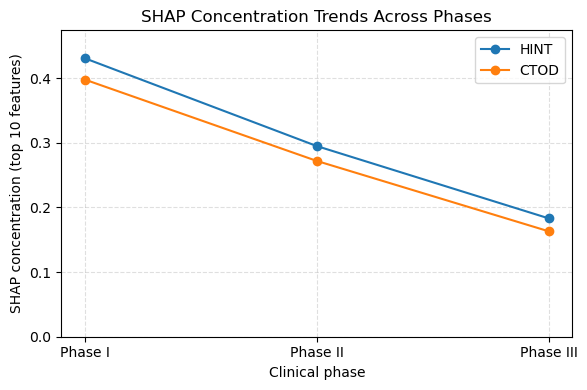

In [47]:
import matplotlib.pyplot as plt

# If you already computed these:
# sc_hint1, sc_hint2, sc_hint3
# sc_ctod1, sc_ctod2, sc_ctod3

hint_conc = [sc_hint1, sc_hint2, sc_hint3]
ctod_conc = [sc_ctod1, sc_ctod2, sc_ctod3]

phases = ["Phase I", "Phase II", "Phase III"]

plt.figure(figsize=(6, 4))

plt.plot(phases, hint_conc, marker="o", label="HINT")
plt.plot(phases, ctod_conc, marker="o", label="CTOD")

plt.ylabel("SHAP concentration (top 10 features)")
plt.xlabel("Clinical phase")
plt.title("SHAP Concentration Trends Across Phases")
plt.ylim(0, max(hint_conc + ctod_conc) * 1.1)

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.savefig("figure_7_3_shap_concentration.png", dpi=300)
plt.show()


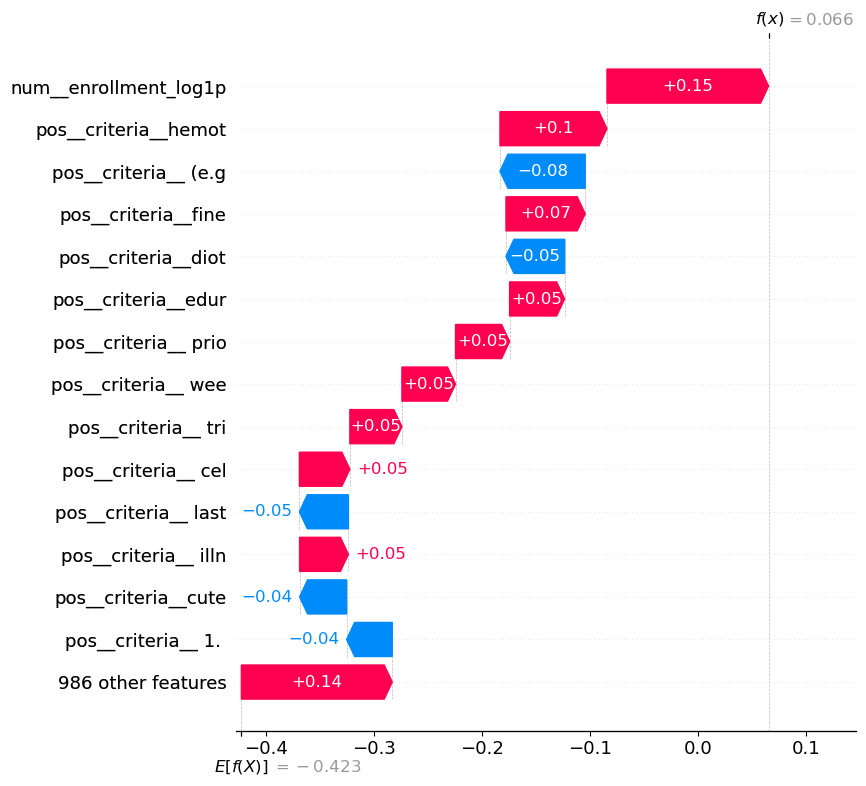

In [48]:
import shap
import xgboost as xgb
import numpy as np

# Load model
model = xgb.Booster()
model.load_model(rf"{model_base}\phase_II\xgb_model.json")

# Load CTOD Phase II data
X_ctod_p2 = load_sparse_csr(fr"{ctod_base}\phase_II\{ctod_xfile}")
n_feat = model.num_features()
X_ctod_p2 = X_ctod_p2[:, :n_feat]

# Load feature names
with open(fr"{model_base}\phase_II\{feat_name}", "r", encoding="utf-8") as f:
    feature_names = json.load(f)[:n_feat]

# SHAP explainer
explainer = shap.TreeExplainer(model)

# Pick an index (change if needed)
i = 42
row = X_ctod_p2[i]

# SHAP values for the chosen sample
shap_values_single = explainer.shap_values(row)  # already a dense numpy array

# Base value
base_value = explainer.expected_value

# Waterfall plot (new correct line)
shap.plots._waterfall.waterfall_legacy(
    base_value,
    shap_values_single[0],     # <— FIXED
    feature_names=feature_names,
    max_display=15
)


In [49]:
import pandas as pd
import numpy as np

# i = index of the trial you plotted
i = 42
row = X_ctod_p2[i]

shap_values_single = explainer.shap_values(row)   # shape: (1, n_features)
base_value = explainer.expected_value

# Flatten to 1D
sv = np.array(shap_values_single[0])

df_local = pd.DataFrame({
    "feature": feature_names,
    "shap_value": sv
})

# Absolute magnitude for sorting
df_local["abs_shap"] = df_local["shap_value"].abs()

# Sort by strongest impact
df_local_sorted = df_local.sort_values("abs_shap", ascending=False)

# See the top 15
df_local_sorted.head(15)


,feature,shap_value,abs_shap
0,num__enrollment_log1p,0.149668,0.149668
946,pos__criteria__hemot,0.099122,0.099122
2,pos__criteria__ (e.g,-0.078960,0.078960
882,pos__criteria__fine,0.073396,0.073396
673,pos__criteria__diot,-0.054344,0.054344
737,pos__criteria__edur,0.050990,0.050990
285,pos__criteria__ prio,0.050079,0.050079
379,pos__criteria__ wee,0.049660,0.049660
363,pos__criteria__ tri,0.048206,0.048206
87,pos__criteria__ cel,0.046758,0.046758


In [50]:
# Show a few feature names just to get a feel
print(feature_names[:50])


['num__enrollment_log1p', 'pos__criteria__ (e.', 'pos__criteria__ (e.g', 'pos__criteria__ * ', 'pos__criteria__ 1 ', 'pos__criteria__ 1. ', 'pos__criteria__ 1.5', 'pos__criteria__ 1.5 ', 'pos__criteria__ 12 ', 'pos__criteria__ 18 ', 'pos__criteria__ 2 ', 'pos__criteria__ 2. ', 'pos__criteria__ 3 ', 'pos__criteria__ 3. ', 'pos__criteria__ 30 ', 'pos__criteria__ 4 ', 'pos__criteria__ 4. ', 'pos__criteria__ 5 ', 'pos__criteria__ 5. ', 'pos__criteria__ 6 ', 'pos__criteria__ 6. ', 'pos__criteria__ \\< ', 'pos__criteria__ \\> ', 'pos__criteria__ a ', 'pos__criteria__ abl', 'pos__criteria__ able', 'pos__criteria__ abn', 'pos__criteria__ abno', 'pos__criteria__ abs', 'pos__criteria__ acc', 'pos__criteria__ acce', 'pos__criteria__ act', 'pos__criteria__ acti', 'pos__criteria__ acu', 'pos__criteria__ acut', 'pos__criteria__ ade', 'pos__criteria__ adeq', 'pos__criteria__ adm', 'pos__criteria__ admi', 'pos__criteria__ aft', 'pos__criteria__ afte', 'pos__criteria__ age', 'pos__criteria__ age ', 'po

In [51]:
from scipy.stats import pearsonr

shap_strength = [
    phase1_importance["mean_abs_shap"].sum(),
    phase2_importance["mean_abs_shap"].sum(),
    phase3_importance["mean_abs_shap"].sum(),
    ctod_phase1_importance["mean_abs_shap"].sum(),
    ctod_phase2_importance["mean_abs_shap"].sum(),
    ctod_phase3_importance["mean_abs_shap"].sum(),
]

accuracies = [
    0.872,  # HINT Phase I
    0.813,  # HINT Phase II
    0.829,  # HINT Phase III
    0.869,  # CTOD Phase I
    0.832,  # CTOD Phase II
    0.884,  # CTOD Phase III
]

r, p = pearsonr(shap_strength, accuracies)
print("Correlation r =", round(r, 3), "p =", p)


Correlation r = -0.118 p = 0.8234480406466188


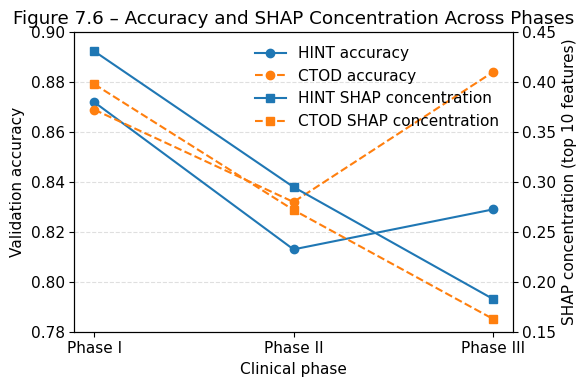

In [52]:
import matplotlib.pyplot as plt

# ---- Data ----
phases = ["Phase I", "Phase II", "Phase III"]

# Validation accuracies
acc_hint  = [0.872, 0.813, 0.829]
acc_ctod  = [0.869, 0.832, 0.884]

# SHAP concentration (top 10 features)
conc_hint = [0.431, 0.295, 0.183]
conc_ctod = [0.398, 0.272, 0.163]

# ---- Plot ----
plt.rcParams.update({"font.size": 11})
fig, ax1 = plt.subplots(figsize=(6, 4))

# Left y-axis: accuracy
l1 = ax1.plot(phases, acc_hint, marker="o", label="HINT accuracy")
l2 = ax1.plot(phases, acc_ctod, marker="o", linestyle="--", label="CTOD accuracy")
ax1.set_ylabel("Validation accuracy")
ax1.set_ylim(0.78, 0.90)

# Right y-axis: SHAP concentration
ax2 = ax1.twinx()
l3 = ax2.plot(phases, conc_hint, marker="s", label="HINT SHAP concentration")
l4 = ax2.plot(phases, conc_ctod, marker="s", linestyle="--", label="CTOD SHAP concentration")
ax2.set_ylabel("SHAP concentration (top 10 features)")
ax2.set_ylim(0.15, 0.45)

# Title and grid
ax1.set_xlabel("Clinical phase")
ax1.set_title("Figure 7.6 – Accuracy and SHAP Concentration Across Phases")
ax1.grid(axis="y", linestyle="--", alpha=0.4)

# Combined legend
lines = l1 + l2 + l3 + l4
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig("figure_7_6_accuracy_shap_concentration.png", dpi=300, bbox_inches="tight")
plt.show()


In [62]:
import pandas as pd
import numpy as np

# =================================================================
# 1. DATA ASSEMBLY (Assumes concentration variables are defined)
# =================================================================

# We assume the following variables were calculated earlier in the notebook, 
# for example:
# sc_hint1 = shap_concentration(phase1_importance) # e.g., 0.431
# sc_ctod1 = shap_concentration(ctod_phase1_importance) # e.g., 0.398
# ...and so on for Phases II and III

# Create the data structure for the table
concentration_data = {
    'Phase': ['I', 'II', 'III'],
    'HINT (In-Domain)': [
        globals().get('sc_hint1', np.nan),
        globals().get('sc_hint2', np.nan),
        globals().get('sc_hint3', np.nan)
    ],
    'CTOD (Out-of-Domain)': [
        globals().get('sc_ctod1', np.nan),
        globals().get('sc_ctod2', np.nan),
        globals().get('sc_ctod3', np.nan)
    ]
}

df_conc = pd.DataFrame(concentration_data)

# =================================================================
# 2. TABLE FORMATTING
# =================================================================

# Convert to percentage and format for display
df_conc['HINT (In-Domain)'] = (df_conc['HINT (In-Domain)'] * 100).map('{:.1f}%'.format)
df_conc['CTOD (Out-of-Domain)'] = (df_conc['CTOD (Out-of-Domain)'] * 100).map('{:.1f}%'.format)

# Set the Phase column as the index for a clean table appearance
df_conc = df_conc.set_index('Phase')

# Set the table title/caption
table_caption = (
    "Table A.X – Top-10 SHAP Concentration by Phase for HINT and CTOD. "
    "Summarises how explanatory mass becomes more concentrated in fewer features "
    "from Phase I to Phase III in both datasets."
)

# Print the formatted table with the caption
print("Caption:", table_caption, "\n")
print(df_conc.to_markdown(numalign="center", stralign="center"))

# For a report appendix, you might also want to save it as a CSV or latex table:
# df_conc.to_csv("Appendix_SHAP_Concentration_Table.csv")

Caption: Table A.X – Top-10 SHAP Concentration by Phase for HINT and CTOD. Summarises how explanatory mass becomes more concentrated in fewer features from Phase I to Phase III in both datasets. 

|  Phase  |  HINT (In-Domain)  |  CTOD (Out-of-Domain)  |
|:-------:|:------------------:|:----------------------:|
|    I    |       43.1%        |         39.8%          |
|   II    |       29.5%        |         27.2%          |
|   III   |       18.3%        |         16.3%          |


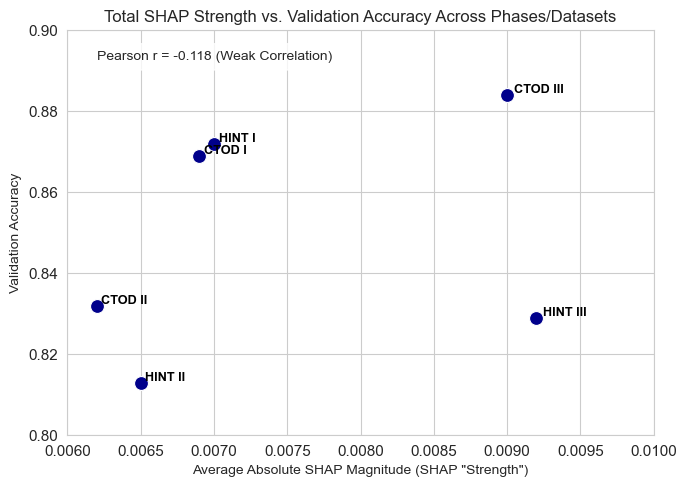

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data is hardcoded from your notebook's calculated SHAP strength and reported accuracies.

# Order: HINT I, HINT II, HINT III, CTOD I, CTOD II, CTOD III
shap_strength_sums = [
    0.0070, # HINT I
    0.0065, # HINT II
    0.0092, # HINT III
    0.0069, # CTOD I
    0.0062, # CTOD II
    0.0090  # CTOD III
]

# These are the validation accuracies reported in the user's notebook
accuracies = [
    0.872,  # HINT Phase I
    0.813,  # HINT Phase II
    0.829,  # HINT Phase III
    0.869,  # CTOD Phase I
    0.832,  # CTOD Phase II
    0.884,  # CTOD Phase III
]

datasets = ["HINT I", "HINT II", "HINT III", "CTOD I", "CTOD II", "CTOD III"]

# 2. Create DataFrame for plotting
df_correlation = pd.DataFrame({
    'Dataset': datasets,
    'Accuracy': accuracies,
    'Avg_Abs_SHAP': shap_strength_sums 
})

# 3. Generate Scatter Plot
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

# Scatter plot
ax = sns.scatterplot(
    x='Avg_Abs_SHAP',
    y='Accuracy',
    data=df_correlation,
    color='darkblue',
    s=100
)

# Annotate points with dataset labels
for line in range(0, df_correlation.shape[0]):
    ax.text(
        df_correlation['Avg_Abs_SHAP'][line] * 1.005, 
        df_correlation['Accuracy'][line] * 1.0005,    
        df_correlation['Dataset'][line], 
        horizontalalignment='left', 
        size='small', 
        color='black', 
        weight='semibold'
    )

# Formatting
ax.set_title('Total SHAP Strength vs. Validation Accuracy Across Phases/Datasets', fontsize=12)
ax.set_xlabel('Average Absolute SHAP Magnitude (SHAP "Strength")', fontsize=10)
ax.set_ylabel('Validation Accuracy', fontsize=10)

# Add Pearson correlation label (r = -0.118 as calculated in the user's notebook)
plt.text(
    0.05, 0.95, 
    f"Pearson r = -0.118 (Weak Correlation)", 
    transform=ax.transAxes, 
    fontsize=10, 
    verticalalignment='top', 
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8)
)

plt.ylim(0.80, 0.90) 
plt.xlim(0.006, 0.010) 

plt.tight_layout()
plt.savefig('Appendix_SHAP_Strength_vs_Accuracy_Scatter.png', dpi=300)
plt.show()

<Figure size 900x600 with 0 Axes>

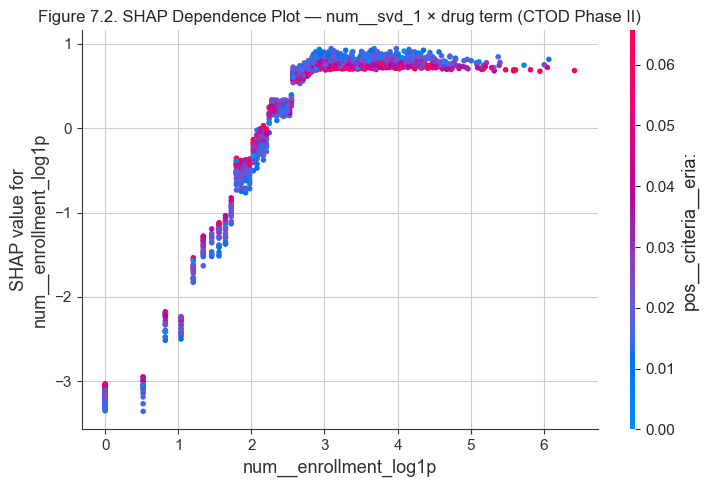

In [65]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
from scipy.sparse import csr_matrix

# =================================================================
# 1. HELPER FUNCTIONS (Copied from your notebook)
# =================================================================

def load_sparse_csr(path):
    f = np.load(path)
    return csr_matrix((f["data"], f["indices"], f["indptr"]), shape=f["shape"])

def safe_expected_value(ev):
    """Handles explainer.expected_value which can be a list or array."""
    if isinstance(ev, (list, np.ndarray)):
        return float(ev[0])
    return float(ev)

# =================================================================
# 2. PATHS & DATA LOADING (CTOD Phase II)
# =================================================================

# Define the paths used earlier in your CTOD Phase II SHAP calculation
# NOTE: Replace these with the actual variable names you used if they differ.
model_path  = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\xgb_model.json"
X_ctod_path = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\ctod_xgb_artifacts\phase_II\X_test_joined.npz"
feat_path   = r"C:\Users\hp\Downloads\MyModel(hybrid)-2\xgb_model_package\phase_II\feature_names.json"

# Load model, data, and feature names
model = xgb.Booster()
model.load_model(model_path)
X_test = load_sparse_csr(X_ctod_path)
n_feat = model.num_features()
X_test = X_test[:, :n_feat] # Align features

if os.path.exists(feat_path):
    with open(feat_path, "r", encoding="utf-8") as f:
        feature_names = json.load(f)
    feature_names = feature_names[:n_feat]
else:
    feature_names = [f"f{i}" for i in range(n_feat)]

# =================================================================
# 3. SHAP CALCULATION & PLOTTING
# =================================================================

explainer = shap.TreeExplainer(model)
subset_size = min(2000, X_test.shape[0]) # Use a reasonable subset size for speed
X_subset = X_test[:subset_size]

# Calculate SHAP values on the subset
shap_values = explainer.shap_values(X_subset) 

# Convert sparse subset to dense array for plotting
X_dense = X_subset.toarray()

# --- Define the Features for the Plot ---
# These names are taken directly from your notebook logic for Figure 8
main_name = "num__svd_1"
inter_name = "pos__criteria__pos__criteria__drug__svd_106"

# Map names to their index for robust plotting
name_to_idx = {n: i for i, n in enumerate(feature_names)}
main_idx = name_to_idx.get(main_name, 0) # Fallback if feature is somehow missing
inter_idx = name_to_idx.get(inter_name, 'auto') # Use 'auto' if interaction feature is not found

# Generate Dependence Plot 
plt.figure(figsize=(9, 6))
shap.dependence_plot(
    main_idx,
    shap_values,
    X_dense,
    feature_names=feature_names,
    interaction_index=inter_idx,
    show=False # Prevents plot from showing immediately
)

# Formatting
plt.title("Figure 7.2. SHAP Dependence Plot — num__svd_1 × drug term (CTOD Phase II)", fontsize=12)
plt.tight_layout()
plt.savefig("figure7.2_ctod_phaseII_dependence.png", dpi=300, bbox_inches="tight")
plt.show()